#### TC count , Vmax of each TC and Lat of Vmax  time sereis (annual) of IBTrACS and LENS2 and HR
- 1 Australia
    - LENS2
    - HR 
- 2 East Australia
    - LENS2
    - HR 
- 3 West Australia
    - LENS2
    - HR 
- 4 New Zealand
    - LENS2
    - HR<br>
Ming Ge Aug; 2024

In [1]:
import glob
import datetime  
import numpy as np
import pandas as pd

import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from mpl_toolkits.basemap import Basemap
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.colors as co
from matplotlib.lines import Line2D  
import matplotlib.cm as cm
from matplotlib.colors import BoundaryNorm, ListedColormap
from matplotlib.collections import LineCollection

In [2]:
# timeseries graph with trendline
def ts_trendline(df, var_s):
    plt.figure(figsize=(6, 4), dpi=300)
    x = df.index
    x = mdates.date2num(df.index)

    y = df[var_s].tolist()
    z = np.polyfit(x,y,1)
    p = np.poly1d(z)
    plt.plot(df.index, p(x), "g--")
    plt.plot(df.index, df[var_s])
    plt.ylabel(var_s)
    plt.show()
    

In [13]:
def ts_trendline_en_0(year_s, year_e, data_3d):
    
    var_s = ['TC Count', 'Vmax', 'Lat of Vmax']
    n_var = len(var_s)
    xx = range(year_s, year_e+1)

    for nv in range(n_var):
        plt.figure(figsize=(6, 4), dpi=300)
        # plot all memebers
        #plt.plot(xx, np.transpose(data_3d[:,:,nv]), linewidth=0.5, color='grey', alpha=0.3)

        # plot ensemble mean
        yy_avg = np.nanmean(data_3d[:,:, nv], axis=0)
        yy_std = np.nanstd(data_3d[:,:, nv], axis=0)
        plt.plot(xx, yy_avg, linewidth=2.0)
        plt.fill_between(xx, yy_avg-yy_std, yy_avg + yy_std, alpha=0.3)

        # plot trend
        yy = yy_avg.tolist()
        zz = np.polyfit(xx,yy,1)
        pp = np.poly1d(zz)
        plt.plot(xx, pp(xx),  linewidth=2)
     
        plt.ylabel(var_s[nv])
        plt.show()

In [3]:
def ts_trendline_en(year_s, year_e, data_3d):
    
    var_s = ['TC Count', 'Vmax', 'Lat of Vmax']
    n_var = len(var_s)
    xx = range(year_s, year_e+1)

    for nv in range(n_var):
        plt.figure(figsize=(6, 4), dpi=300)
        # plot all memebers
        plt.plot(xx, np.transpose(data_3d[:,:,nv]), linewidth=0.5, color='grey', alpha=0.3)

        # plot ensemble mean
        yy_avg = np.nanmean(data_3d[:,:, nv], axis=0)
        yy_std = np.nanstd(data_3d[:,:, nv], axis=0)
        plt.plot(xx, yy_avg, linewidth=2.0)
        plt.fill_between(xx, yy_avg-yy_std, yy_avg + yy_std, alpha=0.3)

        # plot trend
        yy = yy_avg.tolist()
        zz = np.polyfit(xx,yy,1)
        pp = np.poly1d(zz)
        plt.plot(xx, pp(xx),  linewidth=2)
     
        plt.ylabel(var_s[nv])
        plt.show()
        

In [5]:
def rd_HR_info(dir_hr, year_s, year_e, extent):
    
    lon_s = extent[0]
    lon_e = extent[1]
    lat_s = extent[2]
    lat_e = extent[3]
    n_year = year_e - year_s + 1
    
    dirs = [ff for ff in glob.glob(dir_hr + "*")]
    n_mem = len(dirs)

    tc_count = np.zeros((n_year)) 
    vmax_1d  = np.zeros((n_year)) ; vmax_1d[:] = np.nan
    lat_vmax = np.zeros((n_year)) ; lat_vmax[:] = np.nan
    data_3d = np.zeros((n_mem, n_year, 3))

    nm = 0
    for dir in dirs:
        tc_count[:] = 0
        for year in range(year_s, year_e + 1):
            name = dir[len(dir_hr) + 8:-4]        
            flnm = dir + '/' + 'CESM_HR_TC_'+ name+'_output_' + str(year) + '_SH.txt'
         
            df_tc = pd.read_csv(flnm, delimiter=', ', engine='python')
            df = df_tc.loc[df_tc['year'].astype(int) == year]
            tc_ids = np.unique(df.track_id.astype(int))
        
            for tc_id in tc_ids:
                df_single = df.loc[df.track_id.astype(int) == tc_id]
             
                lat_1d = df_single.lat.values.astype(float) 
                lon_1d = df_single.lon.values.astype(float) 
                spd_1d = df_single.wind10.values.astype(float)/kt2ms 
            
                lon_1d =np.where(lon_1d < 0, lon_1d+360, lon_1d)

                latmask = np.where((lat_1d>lat_s) & (lat_1d < lat_e))
        
                if(len(latmask[0]) !=0):
                    lat_latmask = lat_1d[latmask]               
                    lon_latmask = lon_1d[latmask]  
                    spd_latmask = spd_1d[latmask] 
            
                    lonmask = np.where((lon_latmask>lon_s) & (lon_latmask < lon_e))
                    if(len(lonmask[0]) !=0):
                        lat_final = lat_latmask[lonmask]
                        lon_final = lon_latmask[lonmask]
                        spd_final = spd_latmask[lonmask]

                        # find location of Vmax
                        argmax_ind = np.argmax(spd_final)
                
                        tc_count[year-year_s] += 1
                        vmax_1d [year-year_s] = np.max(spd_final)
                        lat_vmax[year-year_s] = lat_final[argmax_ind]

        data = np.zeros((n_year, 3))
        data_3d[nm, :,0] = tc_count
        data_3d[nm, :,1] = vmax_1d
        data_3d[nm, :,2] = lat_vmax
    
        nm = nm + 1

    return data_3d

In [6]:
def rd_LENS2_info(dir_lens2, year_s, year_e, extent):
    
    lon_s = extent[0]
    lon_e = extent[1]
    lat_s = extent[2]
    lat_e = extent[3]
    n_year = year_e - year_s + 1

    flnms = [ff for ff in sorted(glob.glob(dir_lens2 + "*WeakThreshold.txt"))]
    n_mem = len(flnms)

    tc_count = np.zeros((n_year)) 
    vmax_1d  = np.zeros((n_year)) ; vmax_1d[:] = np.nan
    lat_vmax = np.zeros((n_year)) ; lat_vmax[:] = np.nan 
    data_3d = np.zeros((n_mem, n_year, 3))

    nm = 0
    for flnm in flnms:
        tc_count[:] = 0
        df_tc = pd.read_csv(flnm, delimiter=', ', engine='python')
        # drop rows containing 'year' in column year
        df_tc = df_tc[~df_tc.year.str.contains("year")]
        for year in range(year_s, year_e + 1):
            df = df_tc.loc[df_tc['year'].astype(int) == year]
            tc_ids = np.unique(df.track_id.astype(int))
            # 29
            for tc_id in tc_ids:
                df_single = df.loc[df.track_id.astype(int) == tc_id]
             
                lat_1d = df_single.lat.values.astype(float) 
                lon_1d = df_single.lon.values.astype(float) 
                spd_1d = df_single.wind10.values.astype(float)/kt2ms 
            
                lon_1d =np.where(lon_1d < 0, lon_1d+360, lon_1d)

                latmask = np.where((lat_1d>lat_s) & (lat_1d < lat_e))
        
                if(len(latmask[0]) !=0):
                    lat_latmask = lat_1d[latmask]               
                    lon_latmask = lon_1d[latmask]  
                    spd_latmask = spd_1d[latmask] 
            
                    lonmask = np.where((lon_latmask>lon_s) & (lon_latmask < lon_e))
                    if(len(lonmask[0]) !=0):
                        lat_final = lat_latmask[lonmask]
                        lon_final = lon_latmask[lonmask]
                        spd_final = spd_latmask[lonmask]

                        # find location of Vmax
                        argmax_ind = np.argmax(spd_final)
                
                        tc_count[year-year_s] += 1
                        vmax_1d [year-year_s] = np.max(spd_final)
                        lat_vmax[year-year_s] = lat_final[argmax_ind]

        data = np.zeros((n_year, 3))
        data_3d[nm, :,0] = tc_count
        data_3d[nm, :,1] = vmax_1d
        data_3d[nm, :,2] = lat_vmax
        nm += 1
    return data_3d

#### Setup

In [7]:
dir_plot  = '/glade/campaign/mmm/c3we/mingge/TC/PLOT/'
dir_lens2 = '/glade/campaign/mmm/c3we/done/pcast/CESM2_LENS/'
dir_hr    = '/glade/campaign/mmm/c3we/done/pcast/CESM_HR/'

dpi = 250

kt2ms = 0.514444
ms2kt = 1.94384

cat_name   = ['TD', 'TS', 'HU1', 'HU2', 'HU3', 'HU4','HU5']
cat_thresh = np.array([34.,   63.,   82.,   95.,   112., 136.])
colors = {'TD': 'blue', 
          'TS': 'green', 
          'HU1': 'cyan', 
          'HU2': 'gold', 
          'HU3': 'coral', 
          'HU4': 'crimson',
          'HU5': 'brown'}

CAT_NAMES = {
    -1: 'TD',
    0: 'TS',
    1: 'HU1',
    2: 'HU2',
    3: 'HU3',
    4: 'HU4',
    5: 'HU5'}

SAFFIR_SIM_CAT = [34, 64, 83, 96, 113, 137, 1000]
norm = BoundaryNorm([0] + SAFFIR_SIM_CAT, len(SAFFIR_SIM_CAT))
CAT_COLORS = cm.inferno(np.linspace(0, 1, len(SAFFIR_SIM_CAT)))
CAT_COLORS = cm.rainbow(np.linspace(0, 1, len(SAFFIR_SIM_CAT)))
cmap = ListedColormap(colors=CAT_COLORS)

year_s = 1980
#year_s = 2020
year_e = 2100
n_year = year_e - year_s + 1

# OZ
lon_s = 100
lon_e = 170
lat_s = -45
lat_e = -5

lon_cen = (lon_s+lon_e)*0.5
proj    = ccrs.PlateCarree(central_longitude=lon_cen)
extent = [lon_s, lon_e, lat_s, lat_e]


#### 1 Australia
-  1.1 LENS2 HR

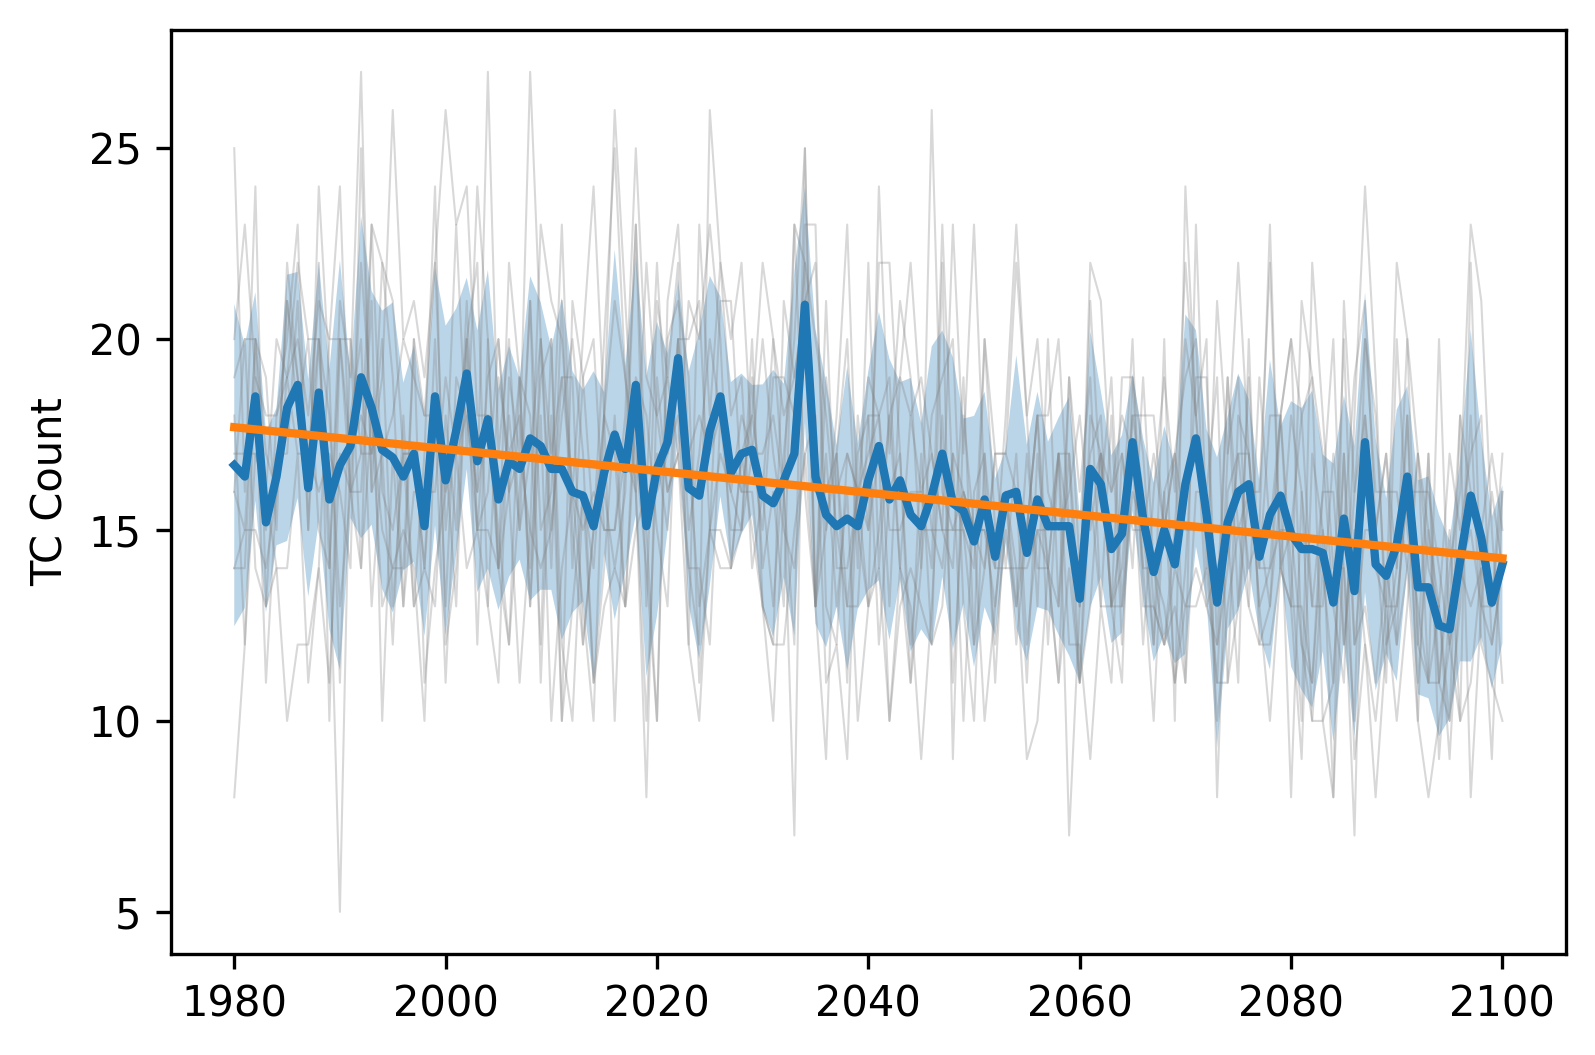

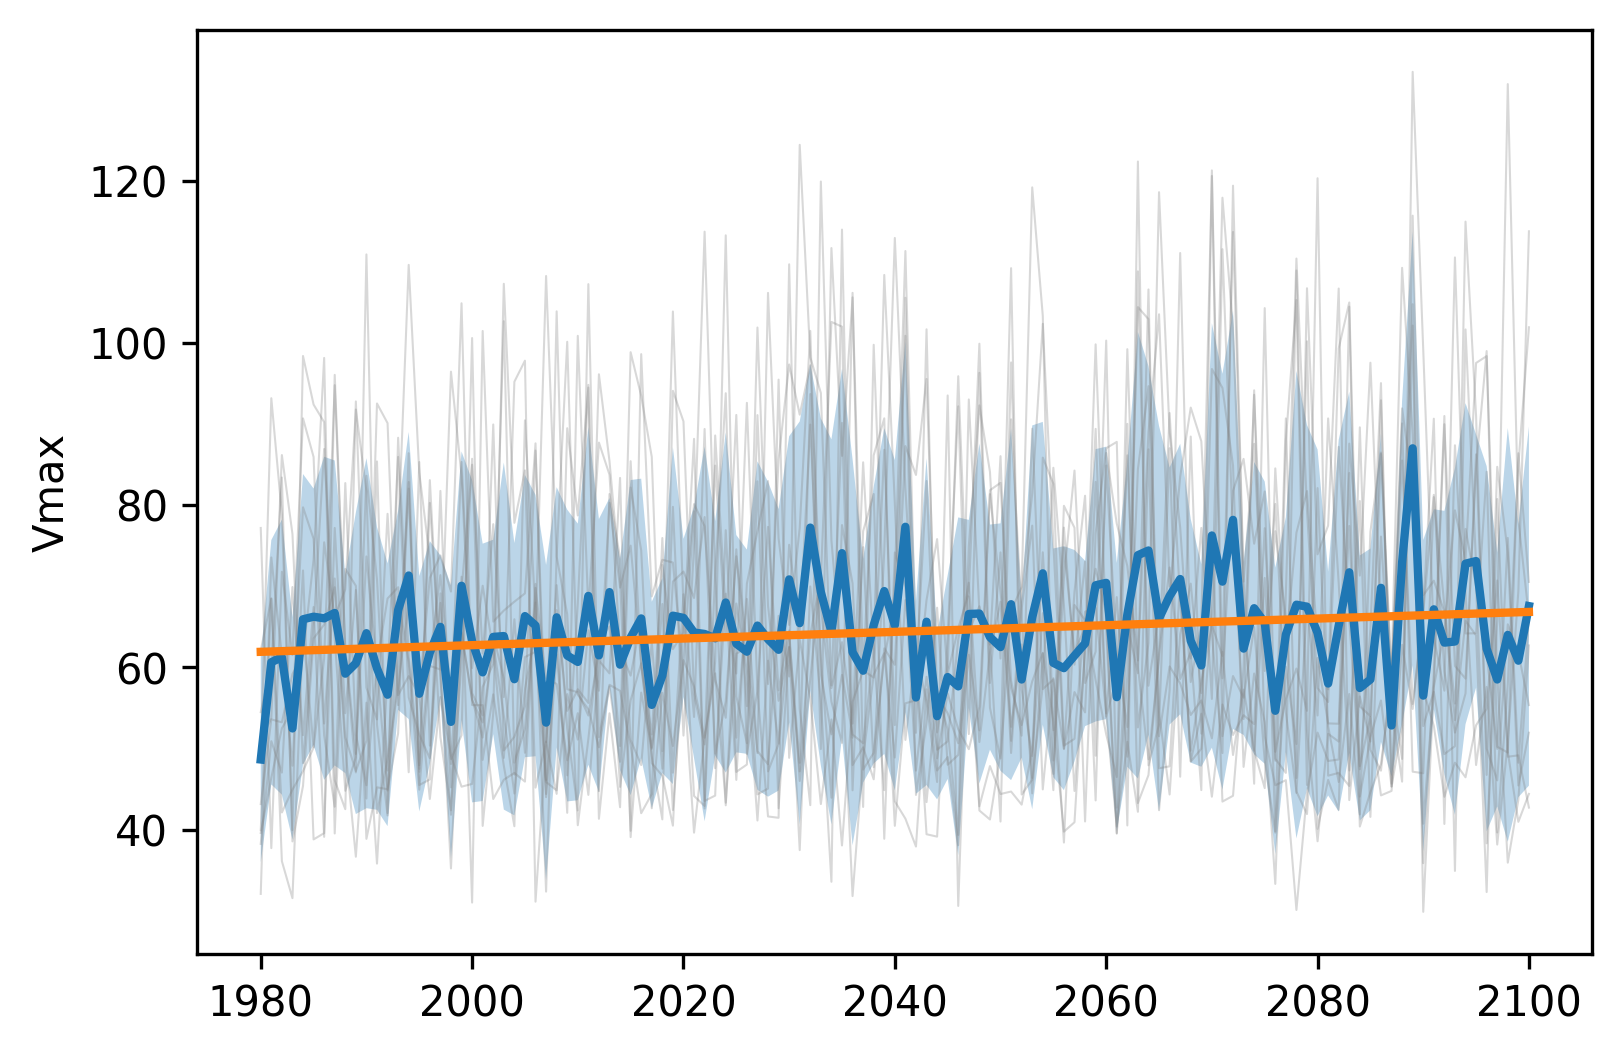

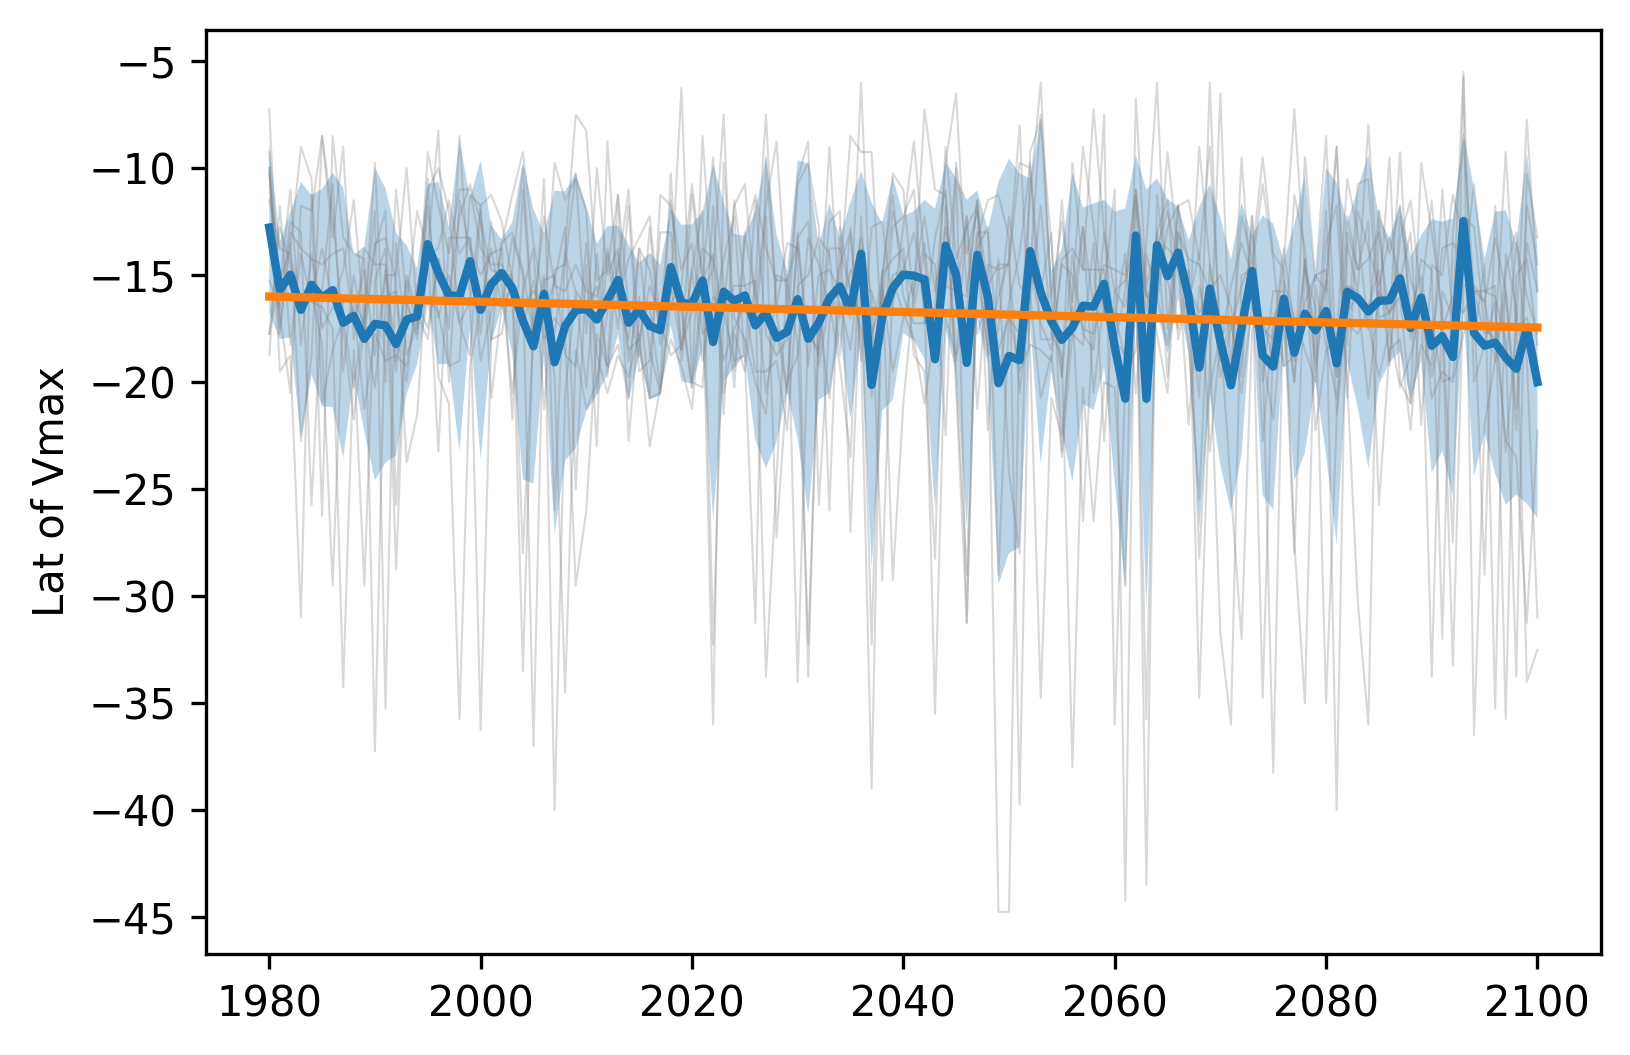

In [11]:
data_3d = rd_HR_info(dir_hr, year_s, year_e, extent) 
ts_trendline_en(year_s, year_e, data_3d) 

- 1.2 LENS2 WeakThreshold 100 member

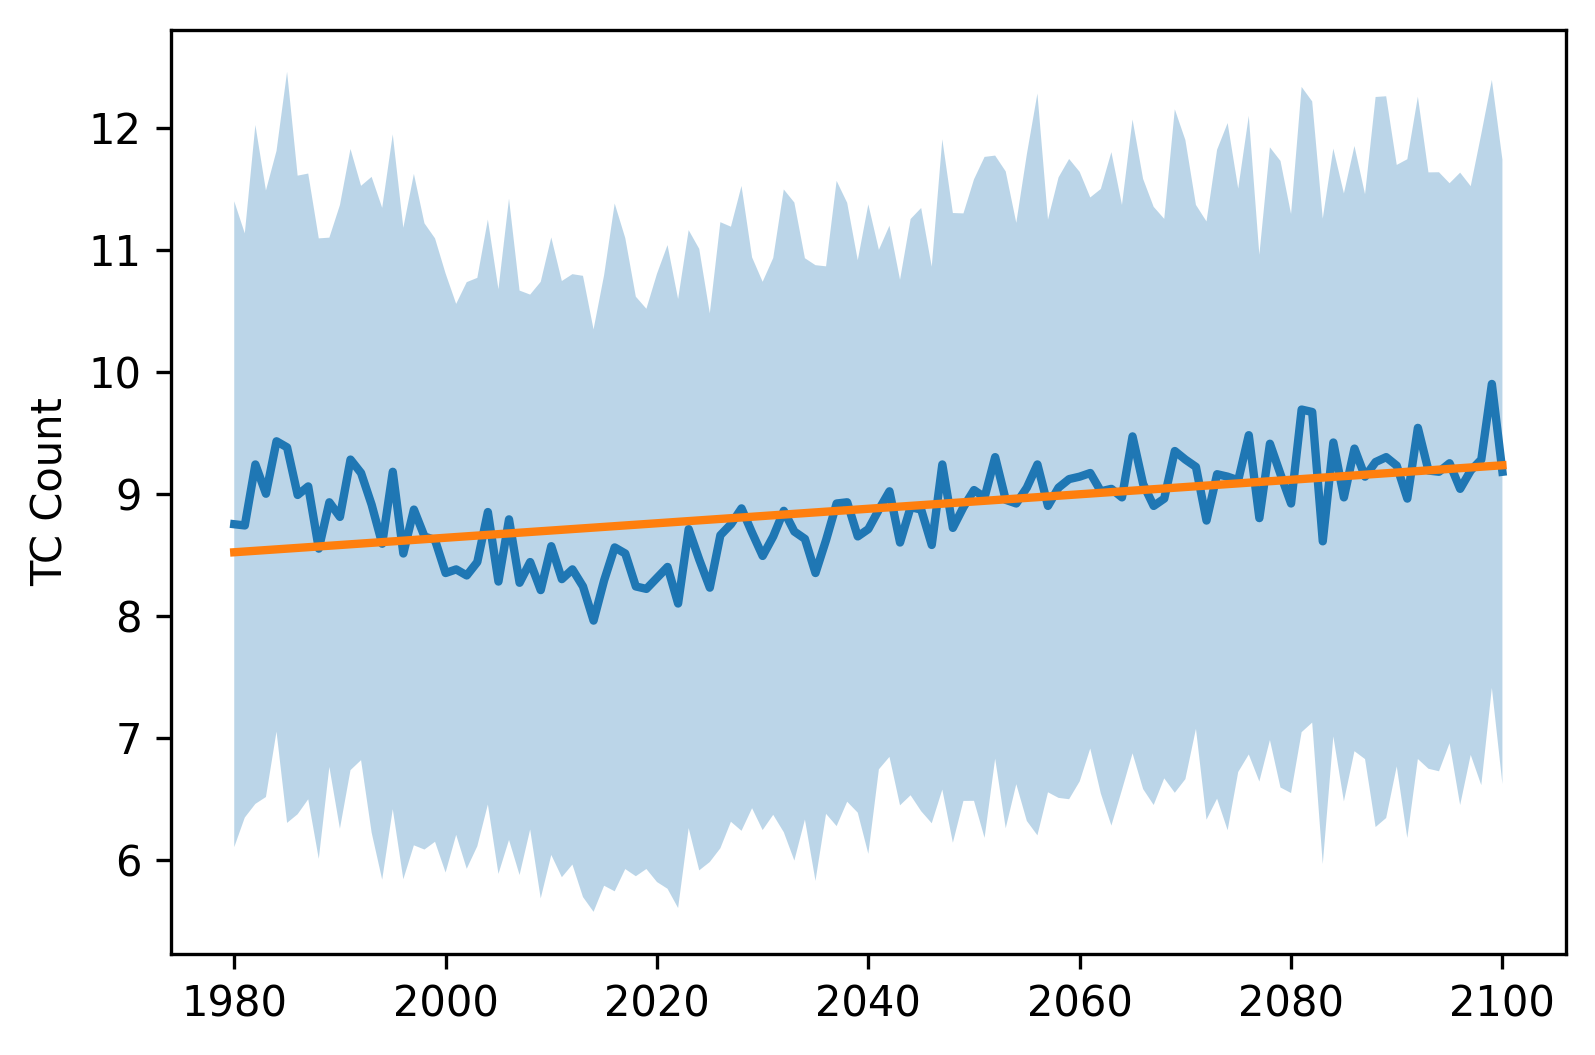

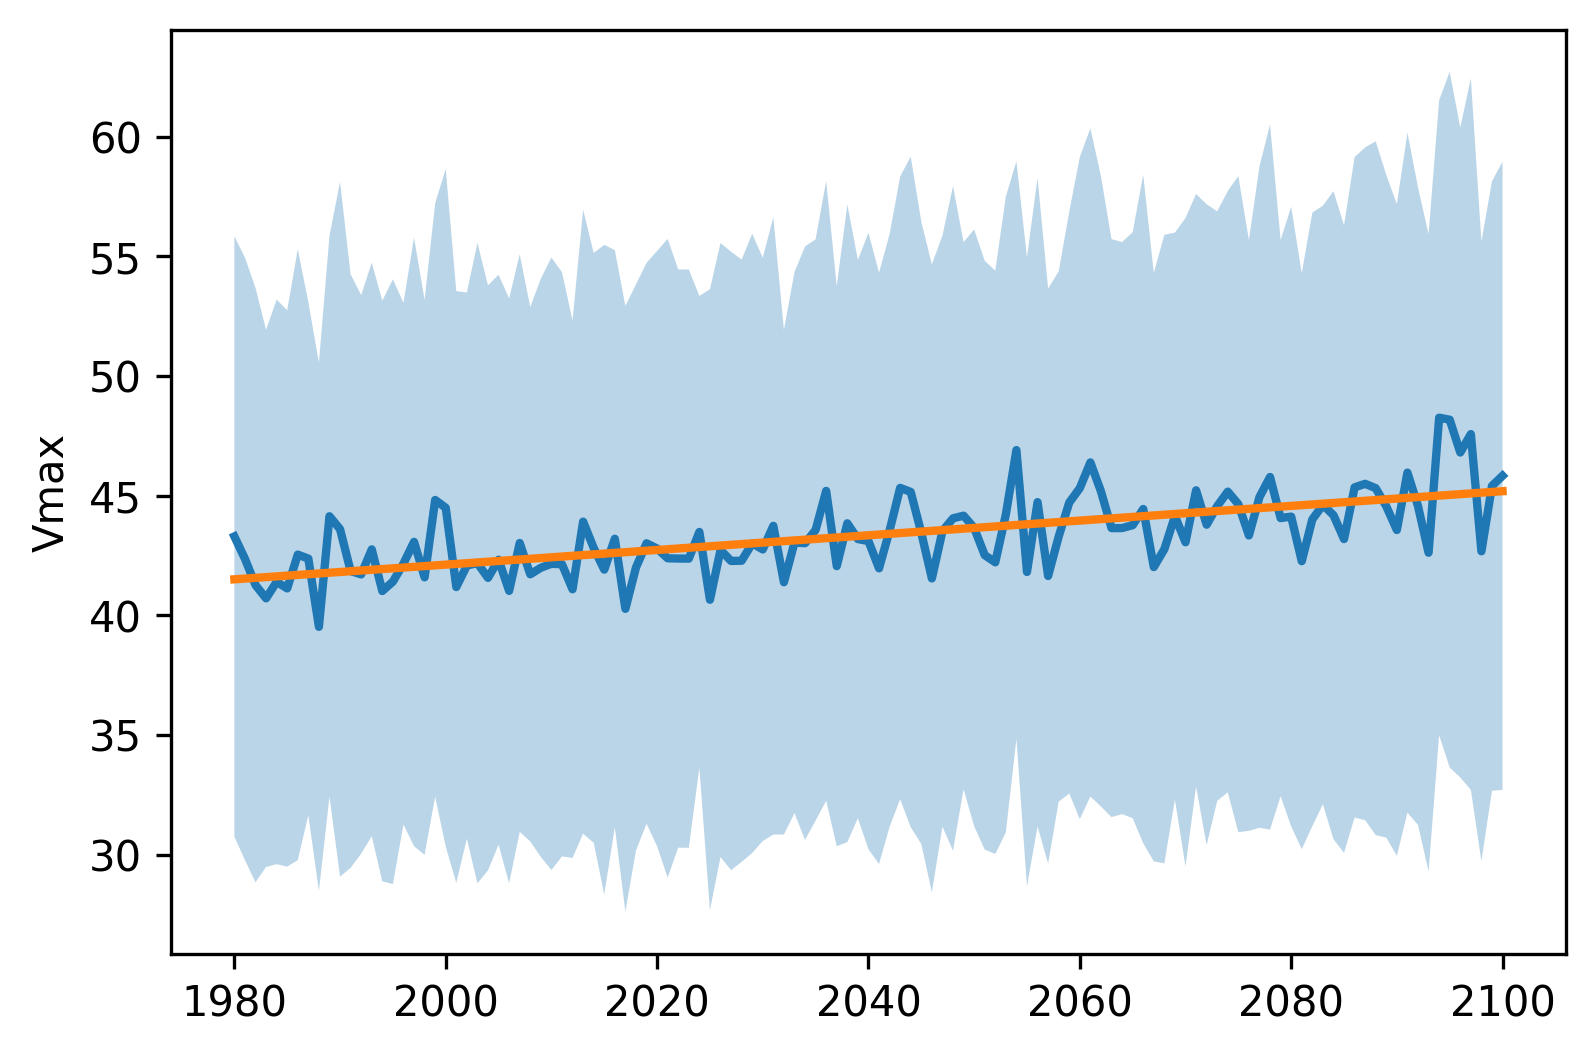

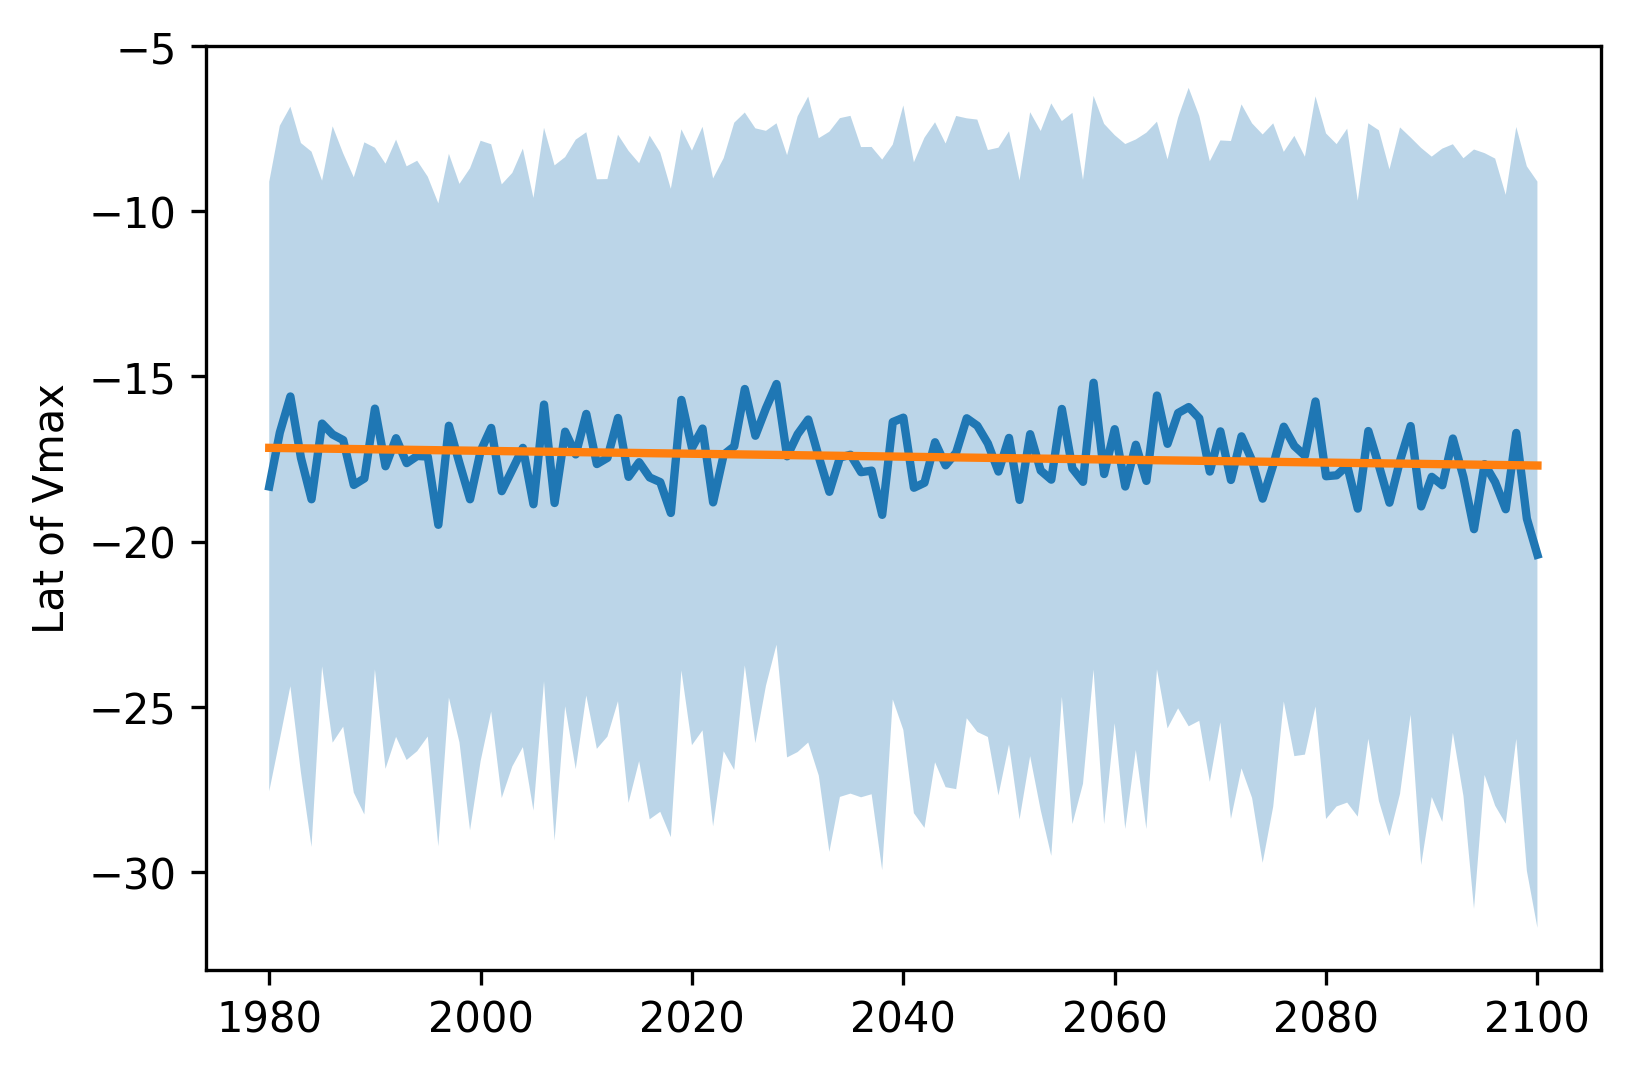

In [14]:
data_3d = rd_LENS2_info(dir_lens2, year_s, year_e, extent)
ts_trendline_en_0(year_s, year_e, data_3d)

#### 2 East Australia

- 2.1 LENS2 HR 10 member

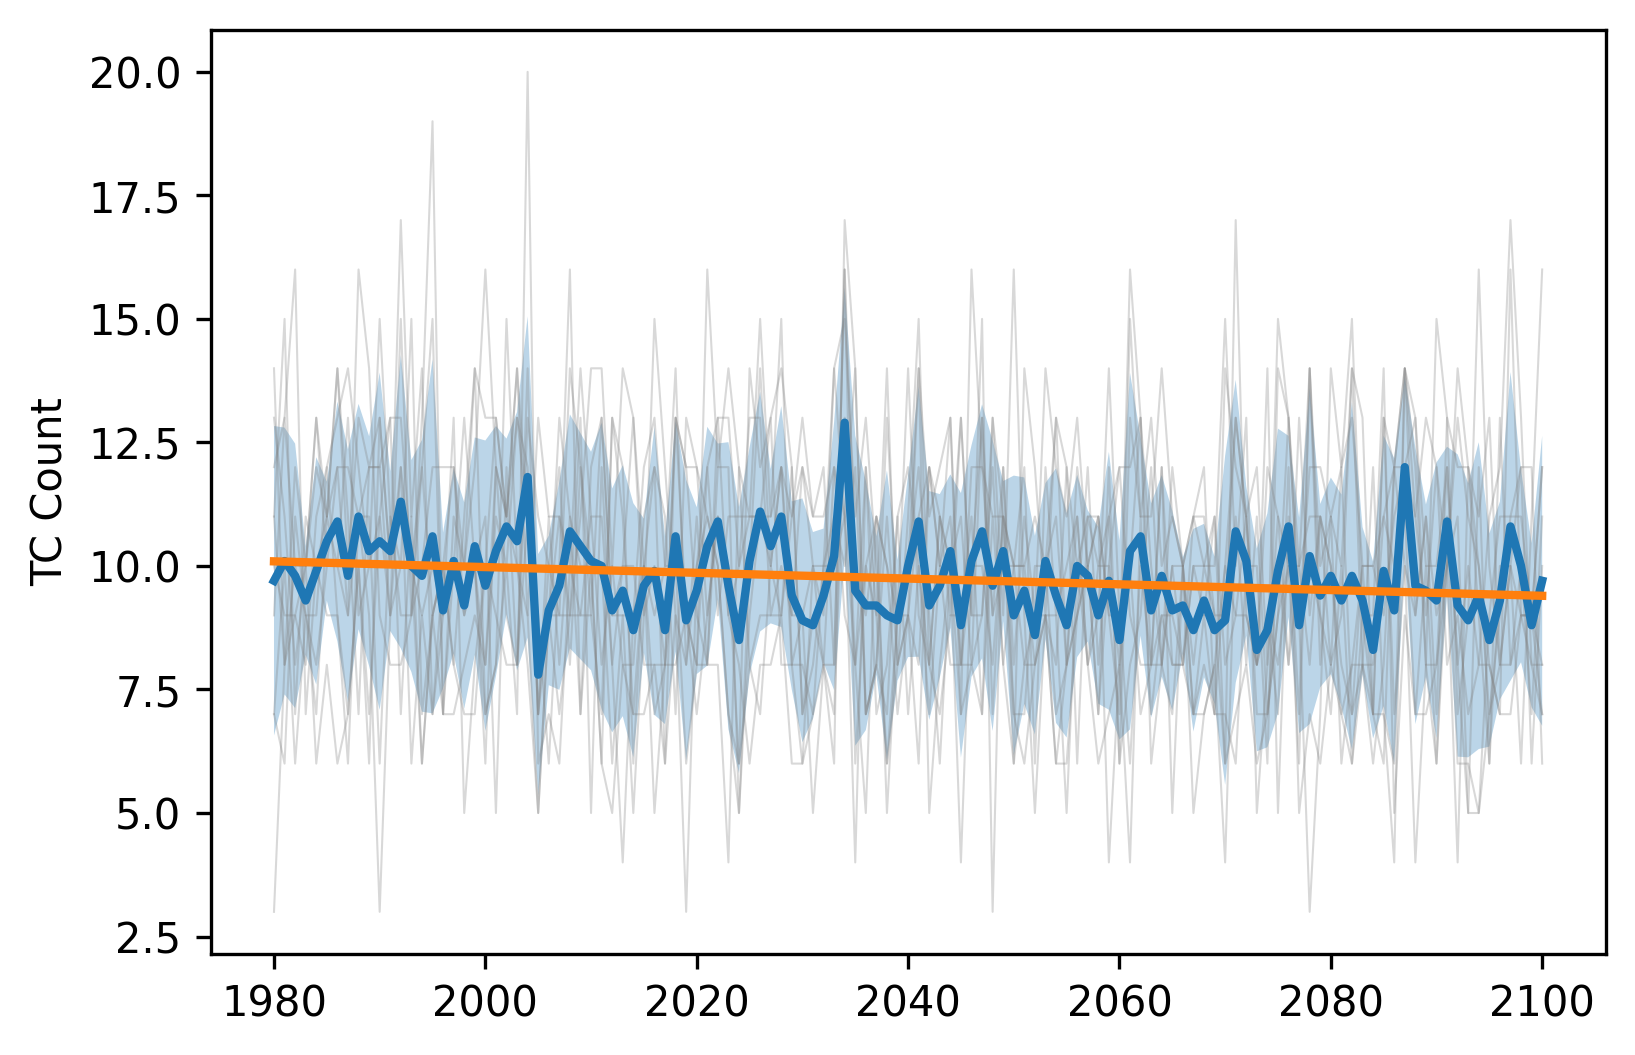

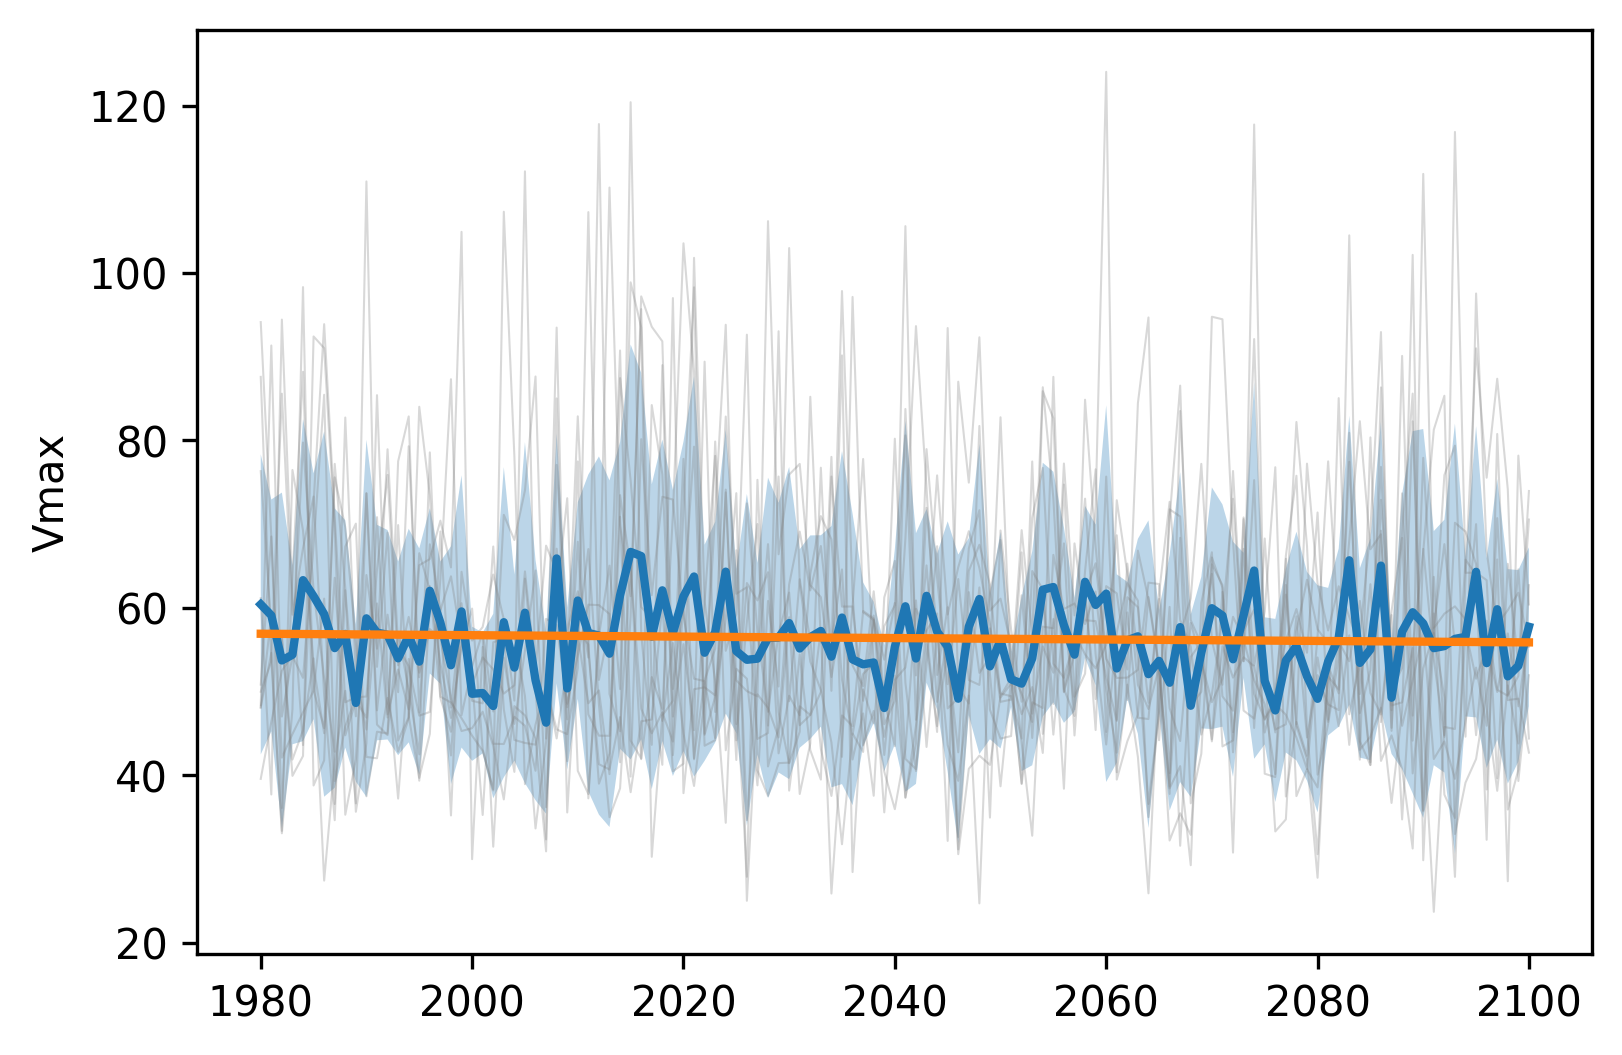

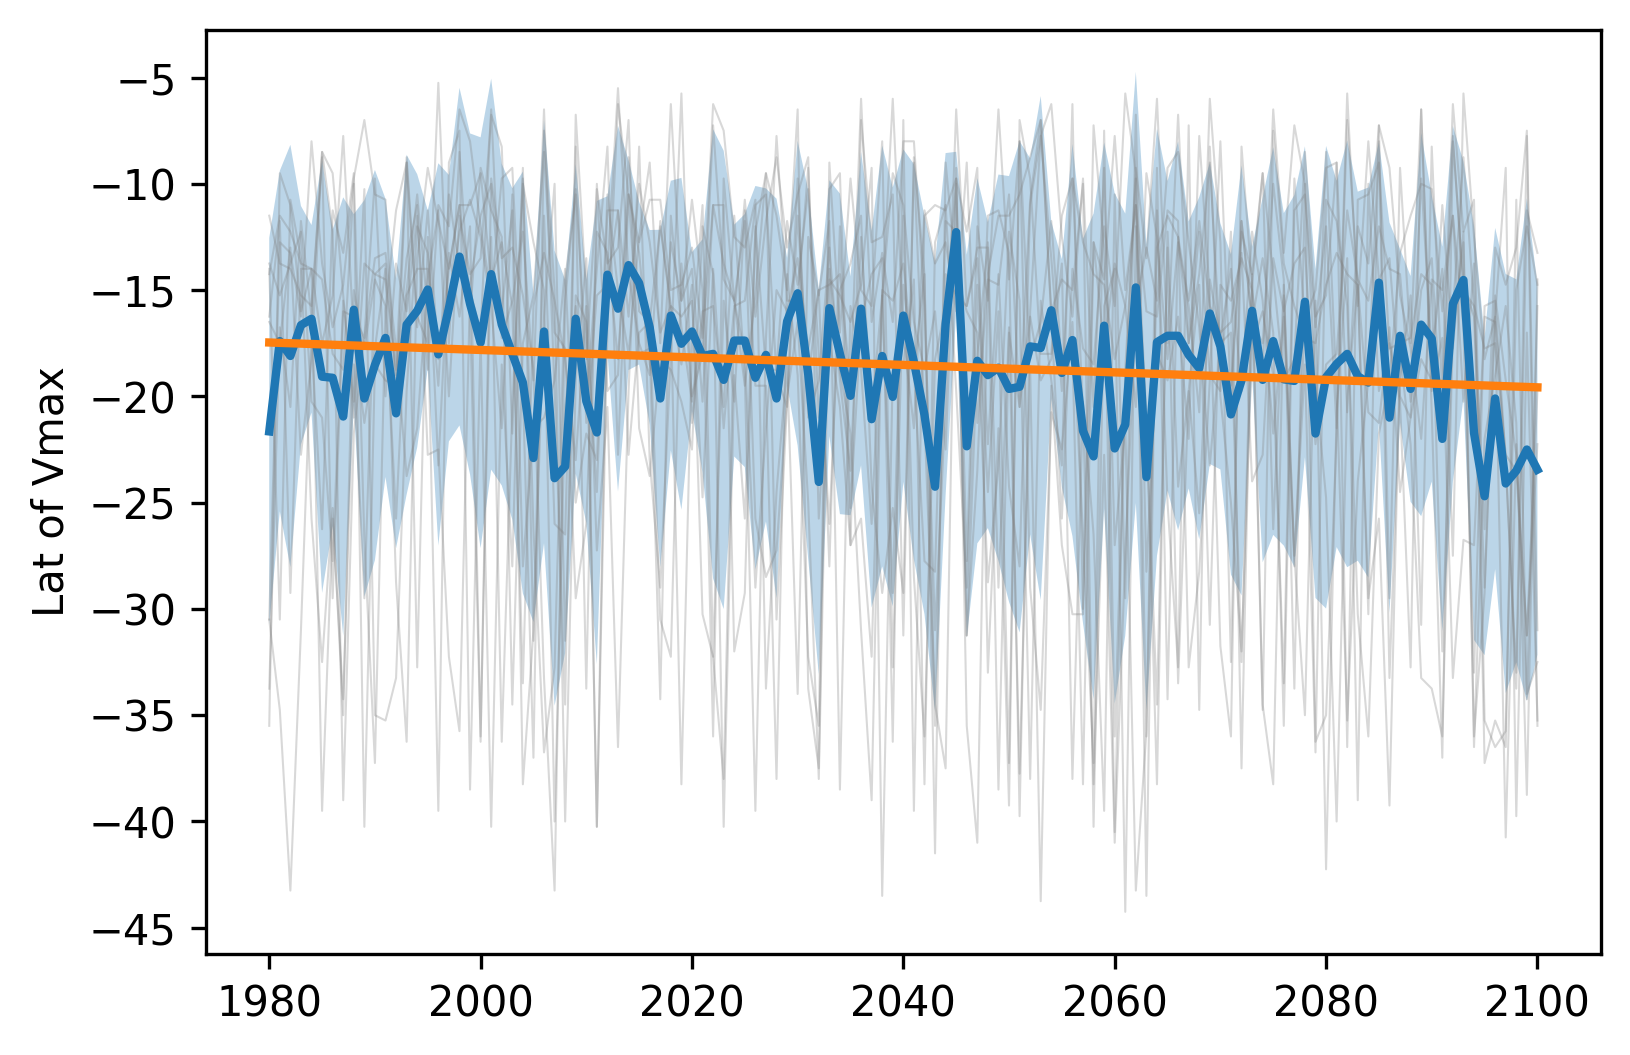

In [15]:
# EOZ
lon_s = 135
lon_e = 170
lat_s = -45
lat_e = -5

lon_cen = (lon_s+lon_e)*0.5
proj    = ccrs.PlateCarree(central_longitude=lon_cen)
extent = [lon_s, lon_e, lat_s, lat_e]
data_3d = rd_HR_info(dir_hr, year_s, year_e, extent) 
ts_trendline_en(year_s, year_e, data_3d)

- 2.2 LENS2 WeakThreshold 100 member

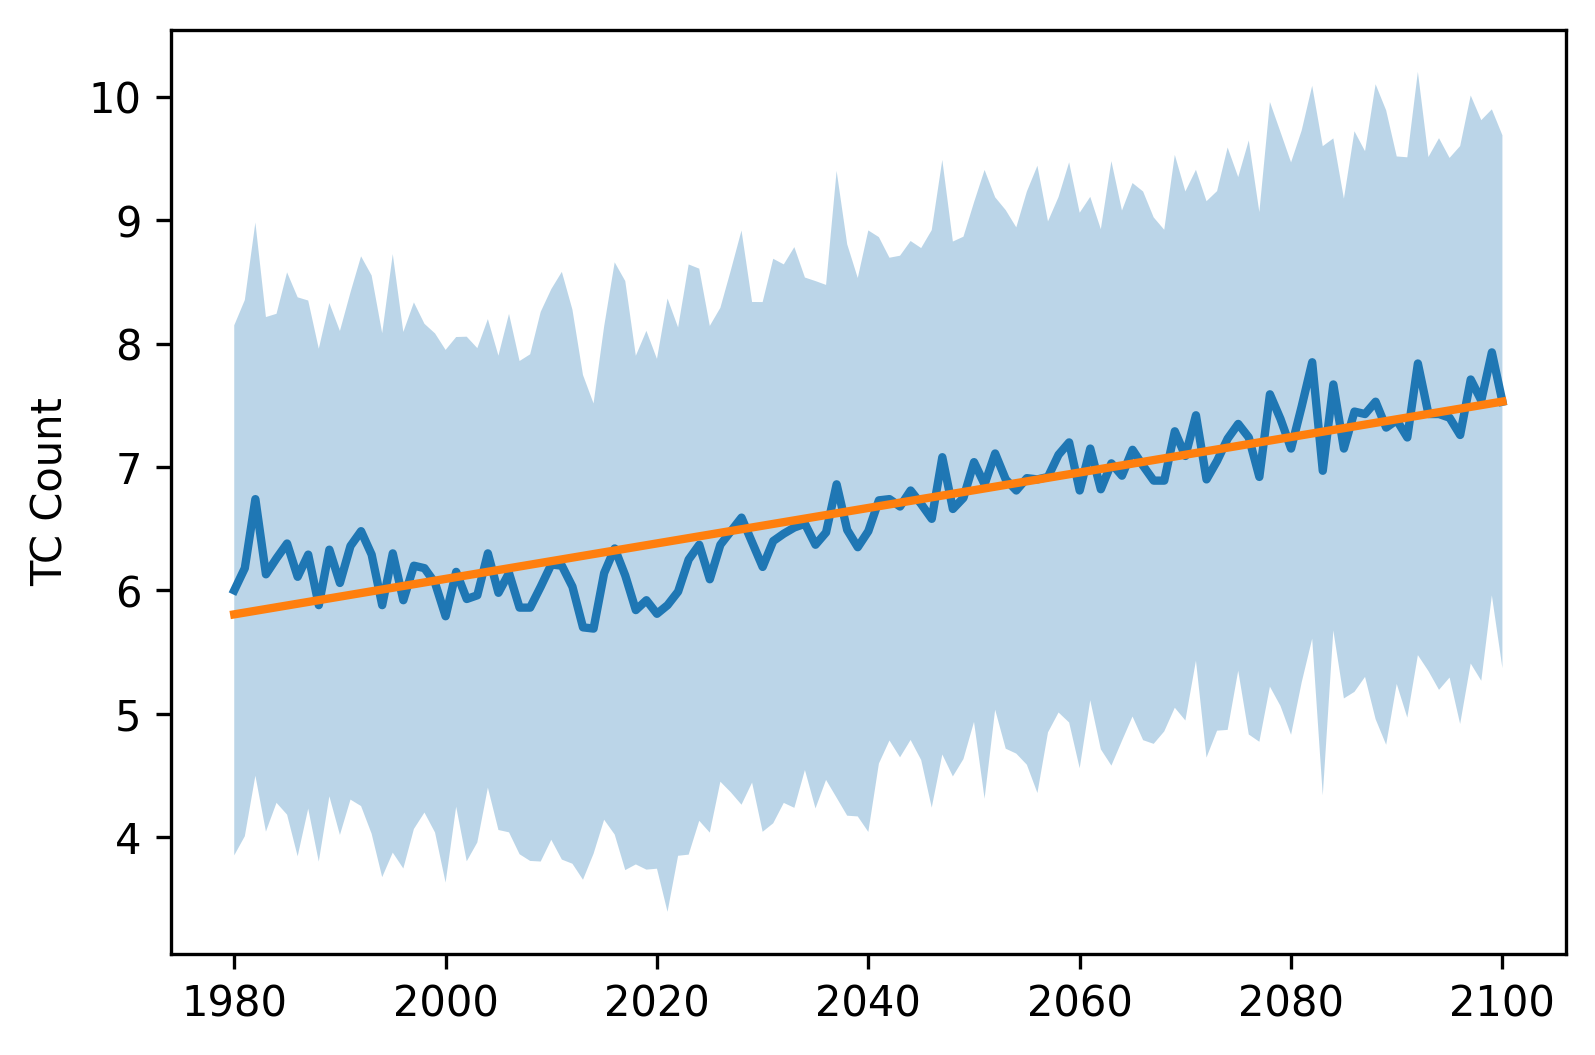

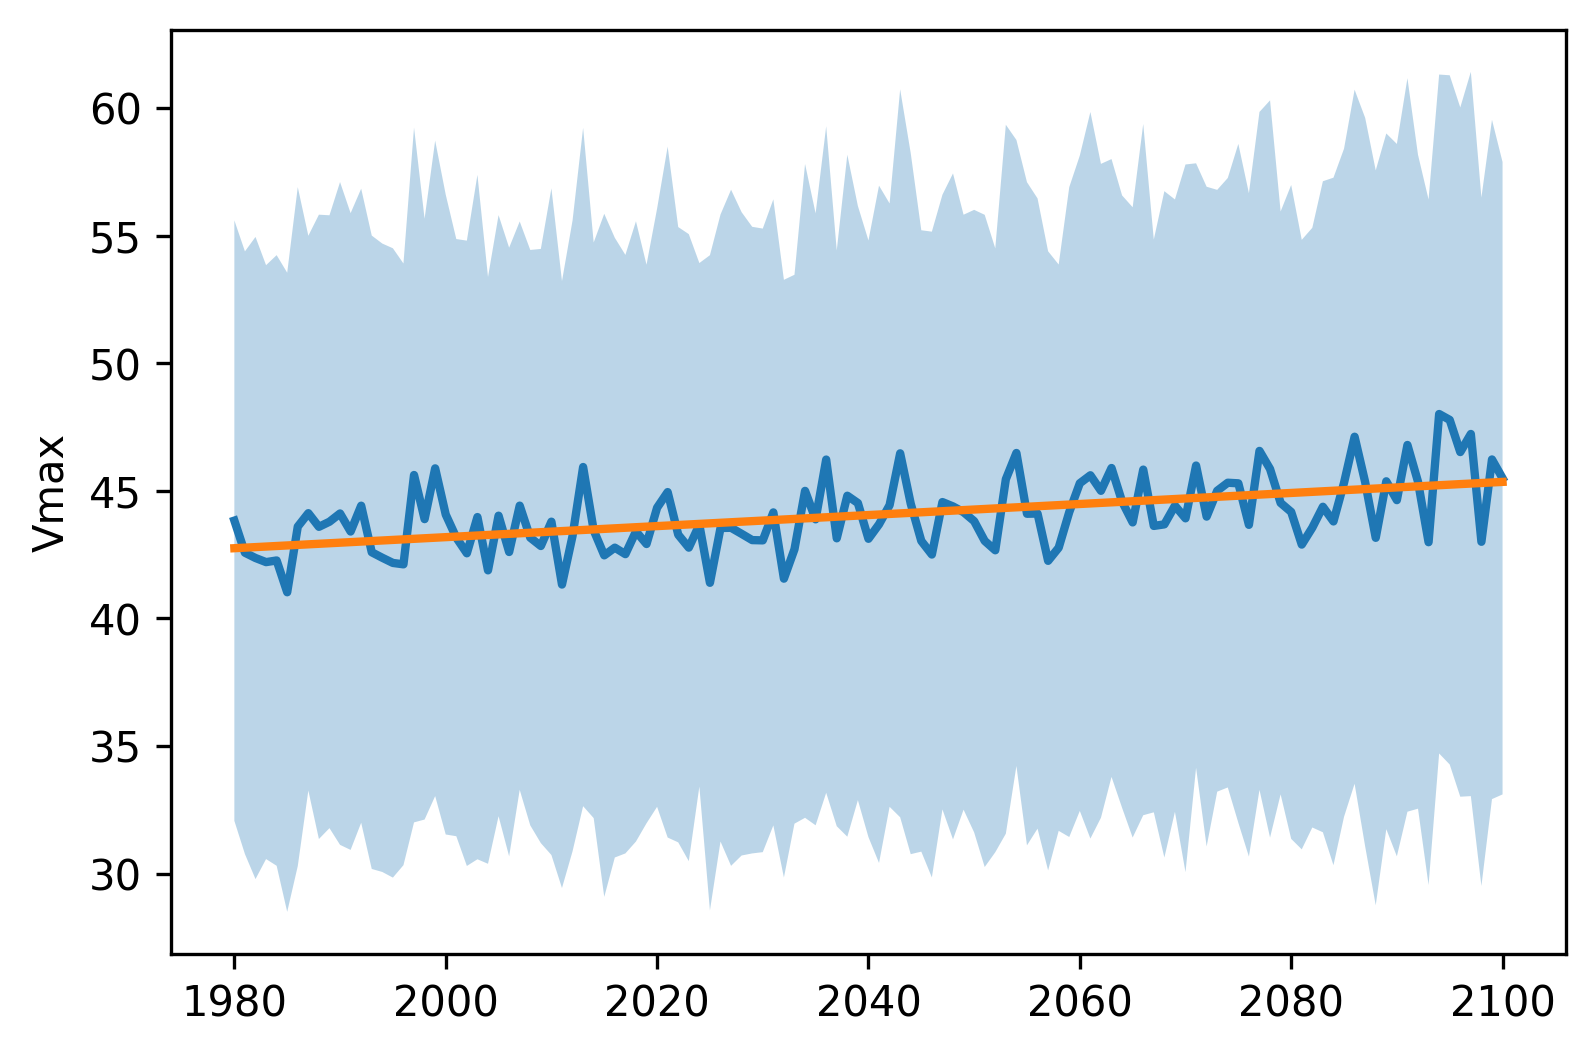

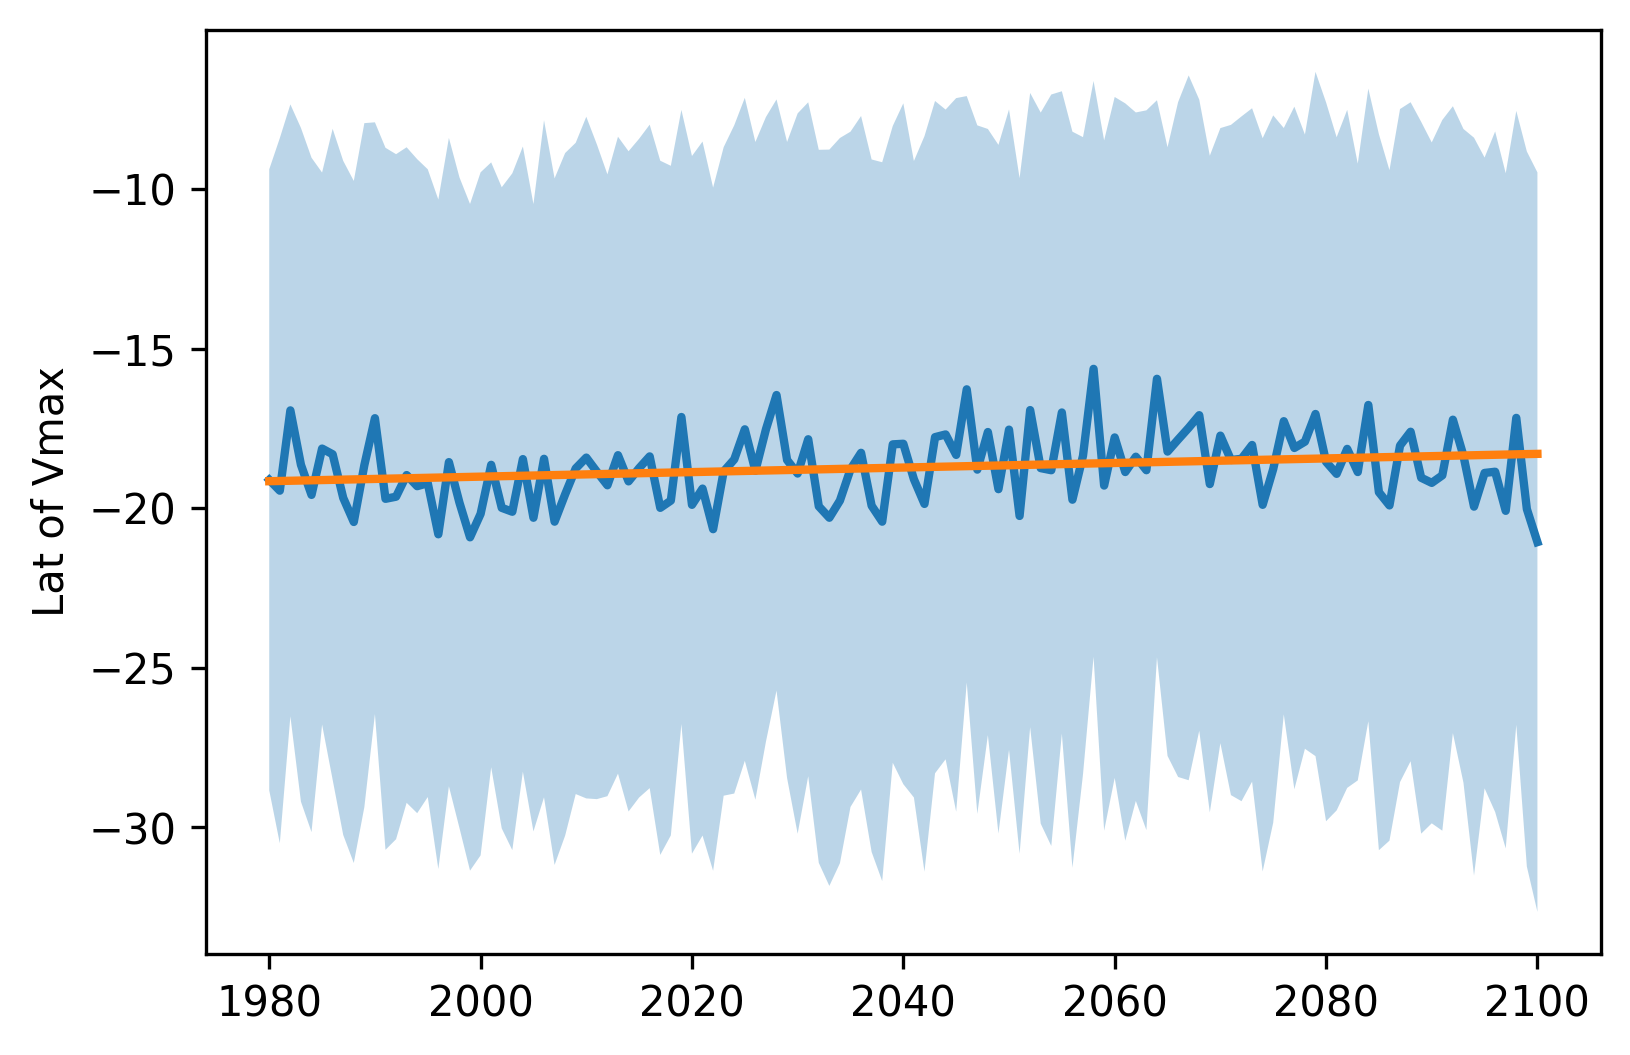

In [16]:
%%time
data_3d = rd_LENS2_info(dir_lens2, year_s, year_e, extent)
ts_trendline_en_0(year_s, year_e, data_3d)

#### 3 West Australia
- 3.1 LENS2 HR

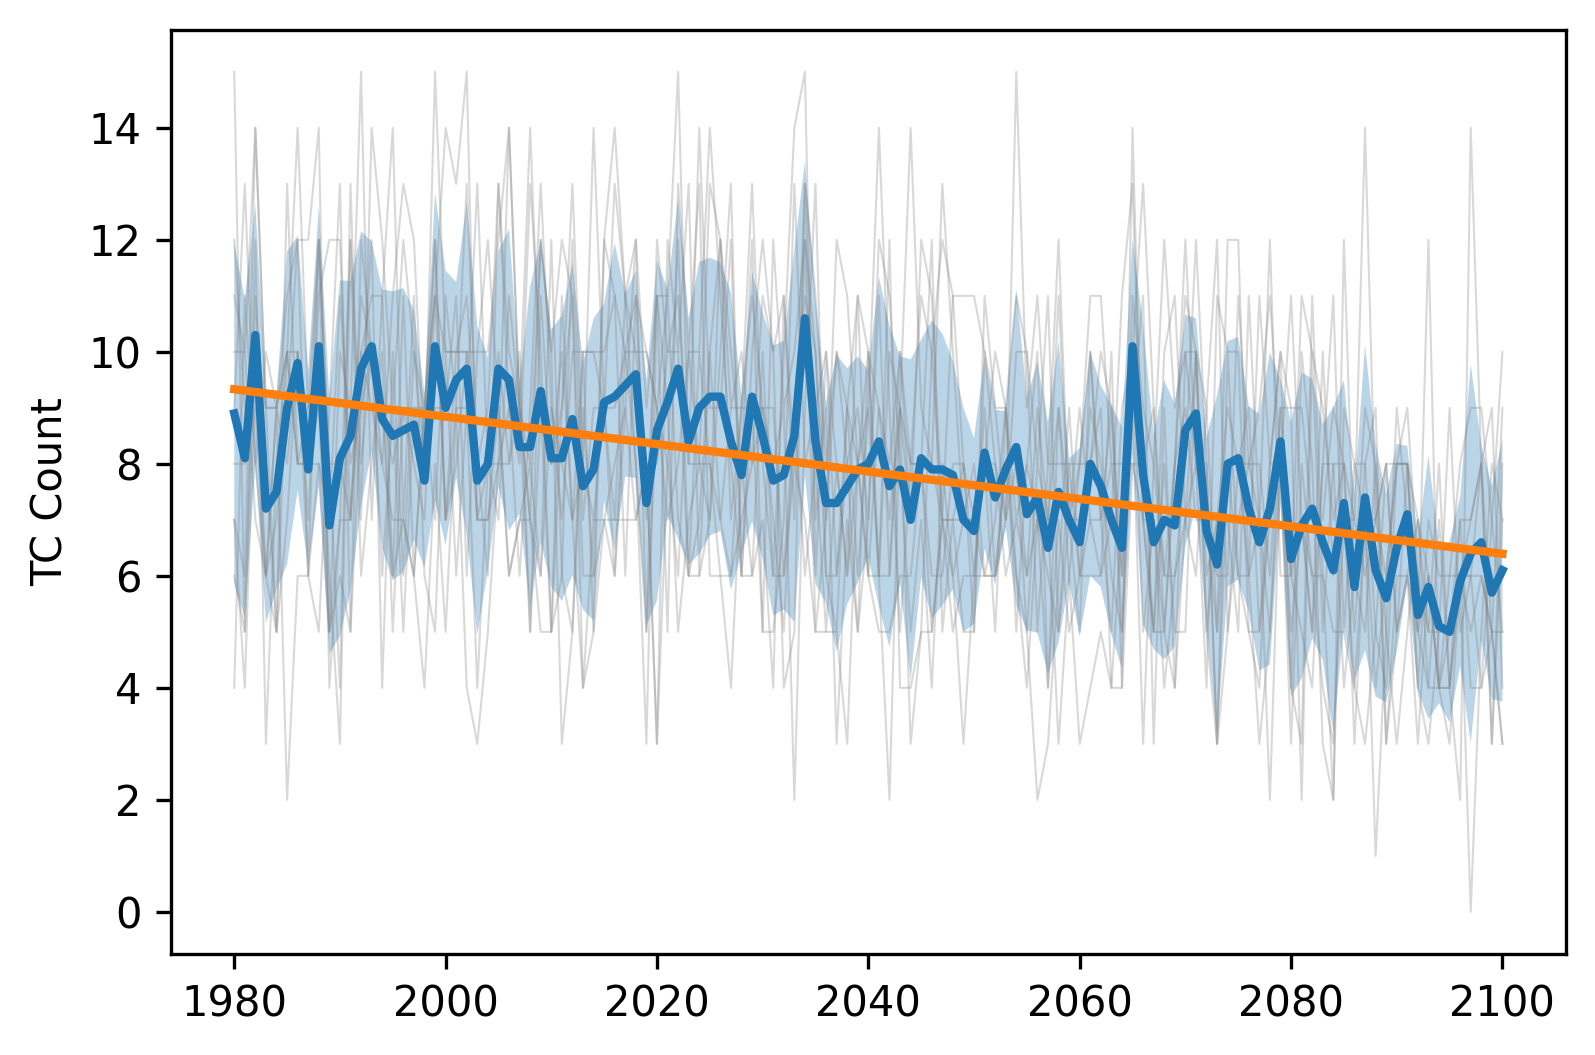

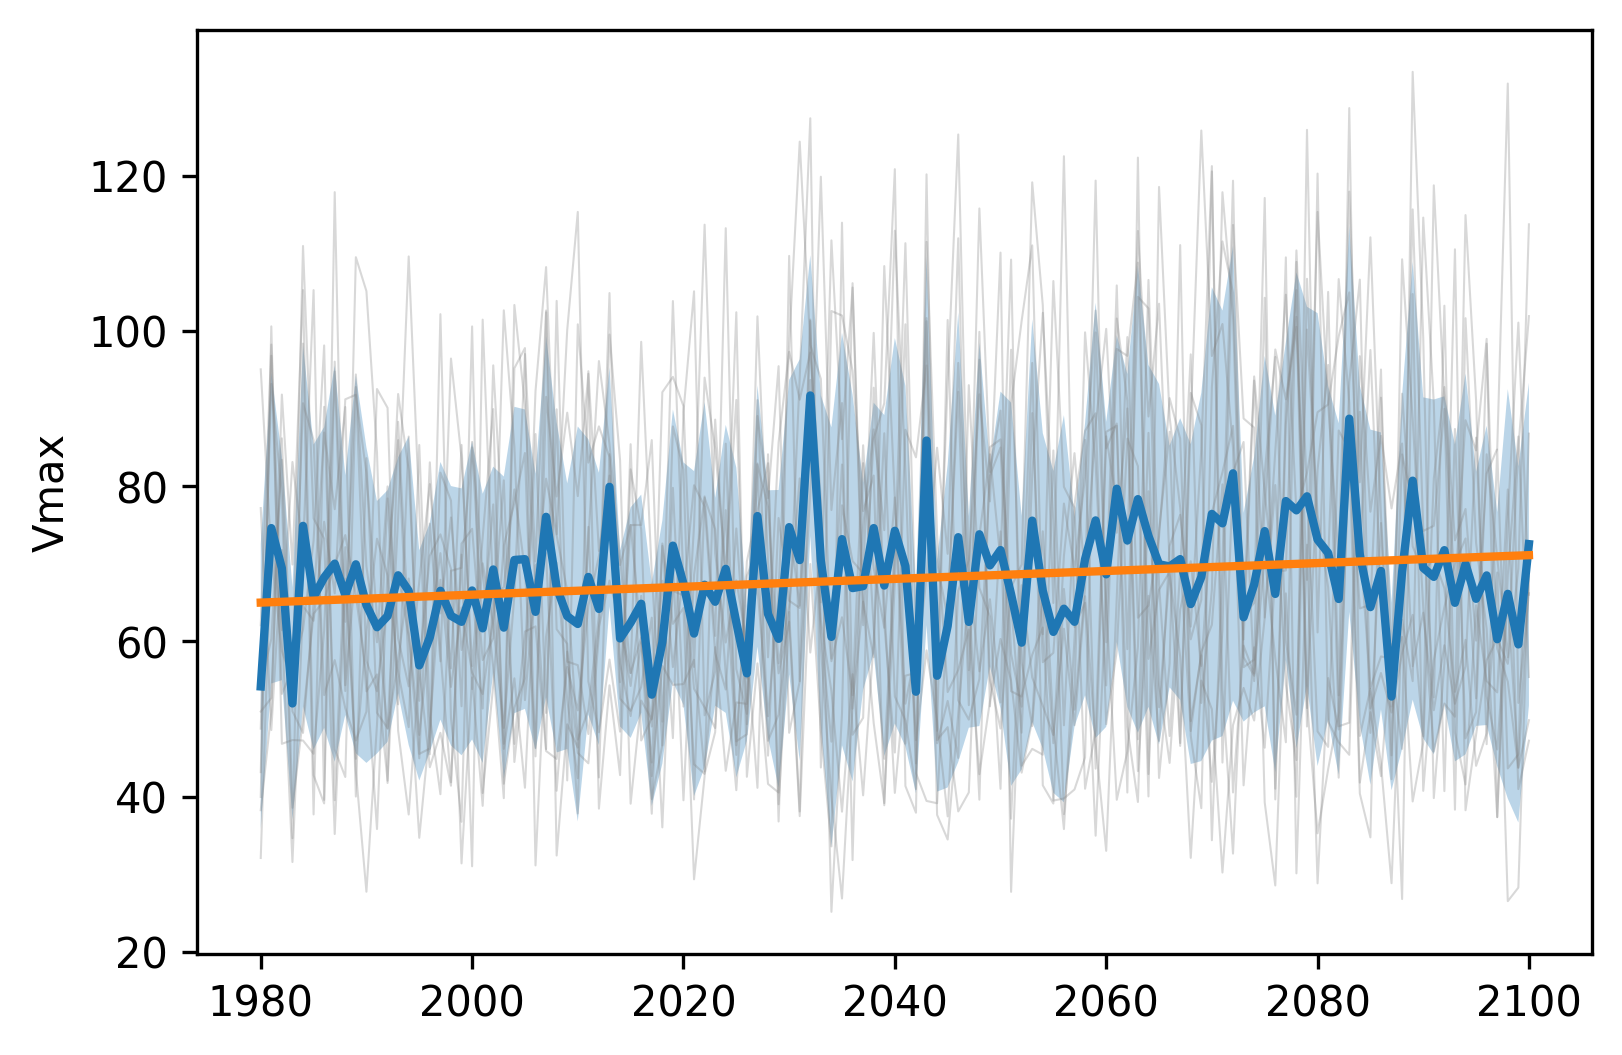

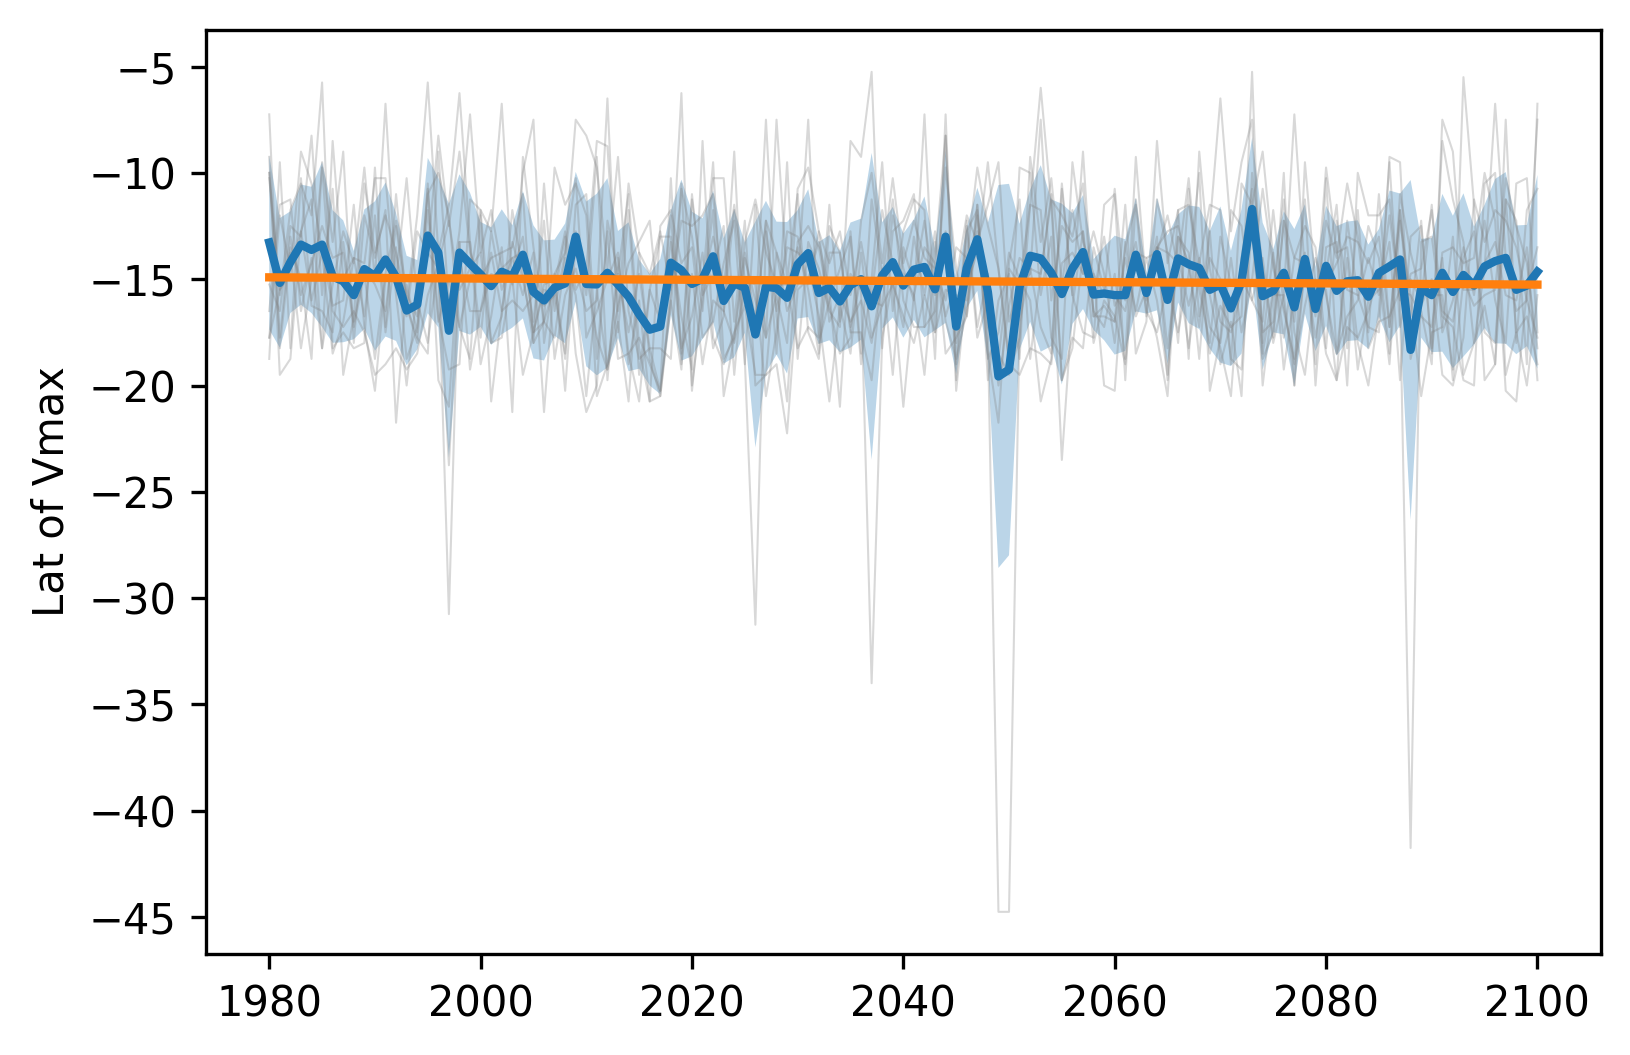

In [17]:
lon_s = 100
lon_e = 135
lat_s = -45
lat_e = -5

lon_cen = (lon_s+lon_e)*0.5
proj    = ccrs.PlateCarree(central_longitude=lon_cen)
extent = [lon_s, lon_e, lat_s, lat_e]
data_3d = rd_HR_info(dir_hr, year_s, year_e, extent) 
ts_trendline_en(year_s, year_e, data_3d) 

- 3.2 LENS2 WeakThreshold 100 member

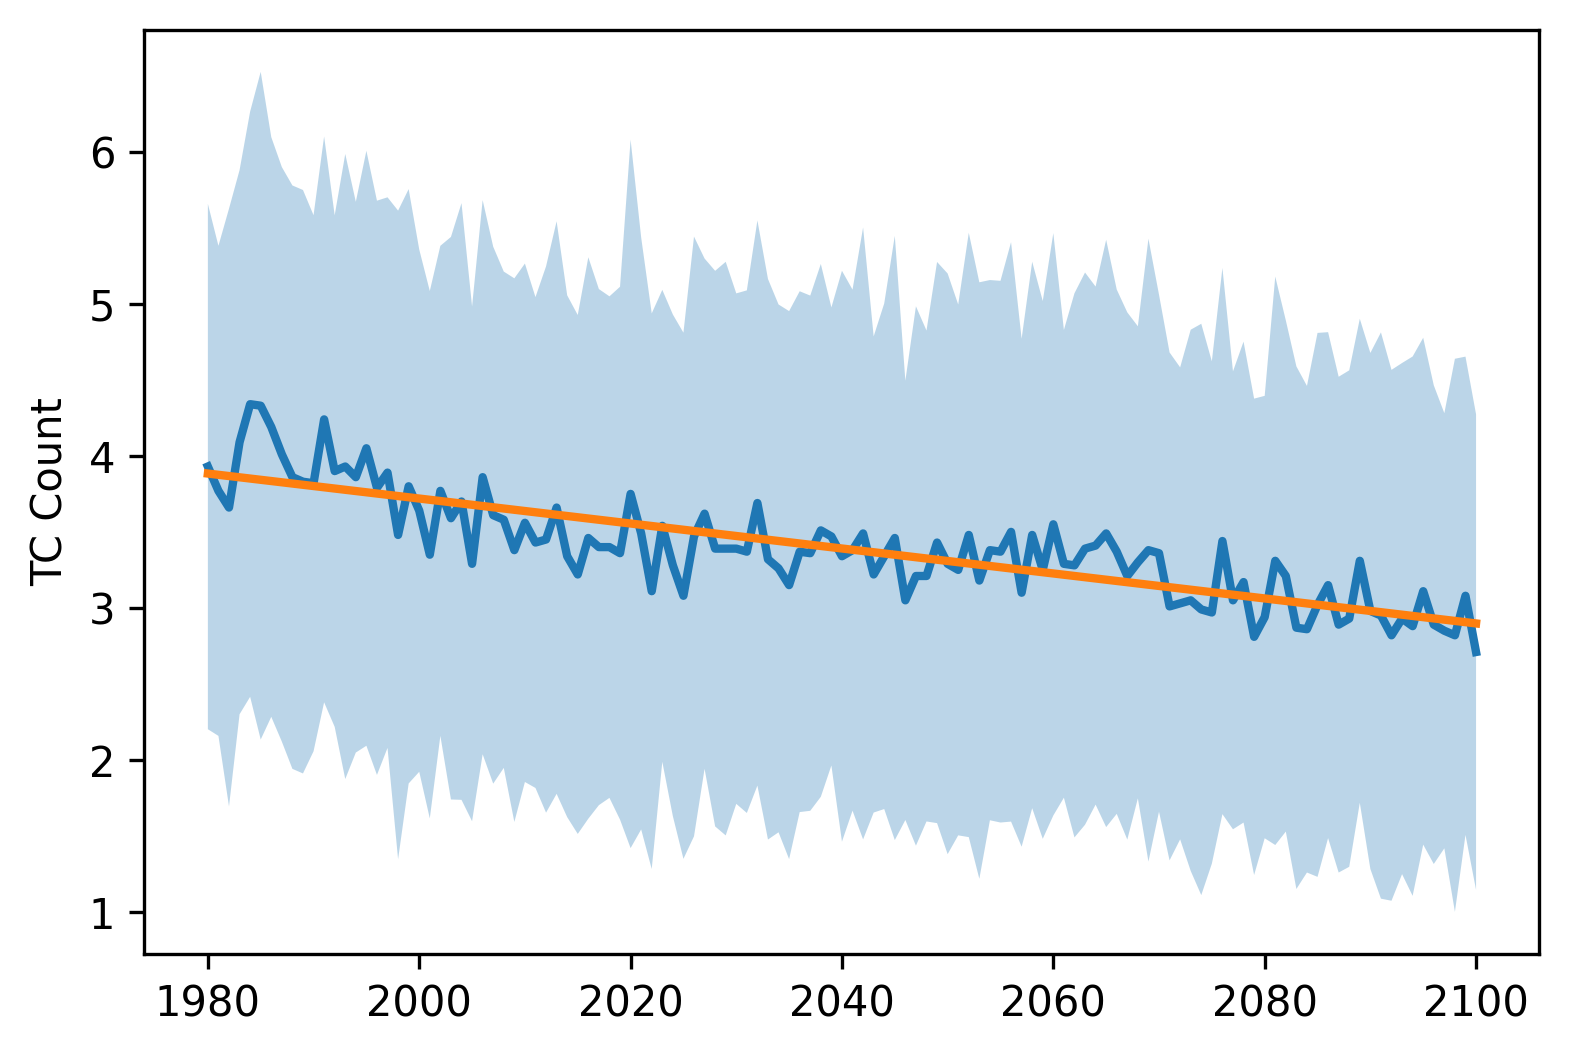

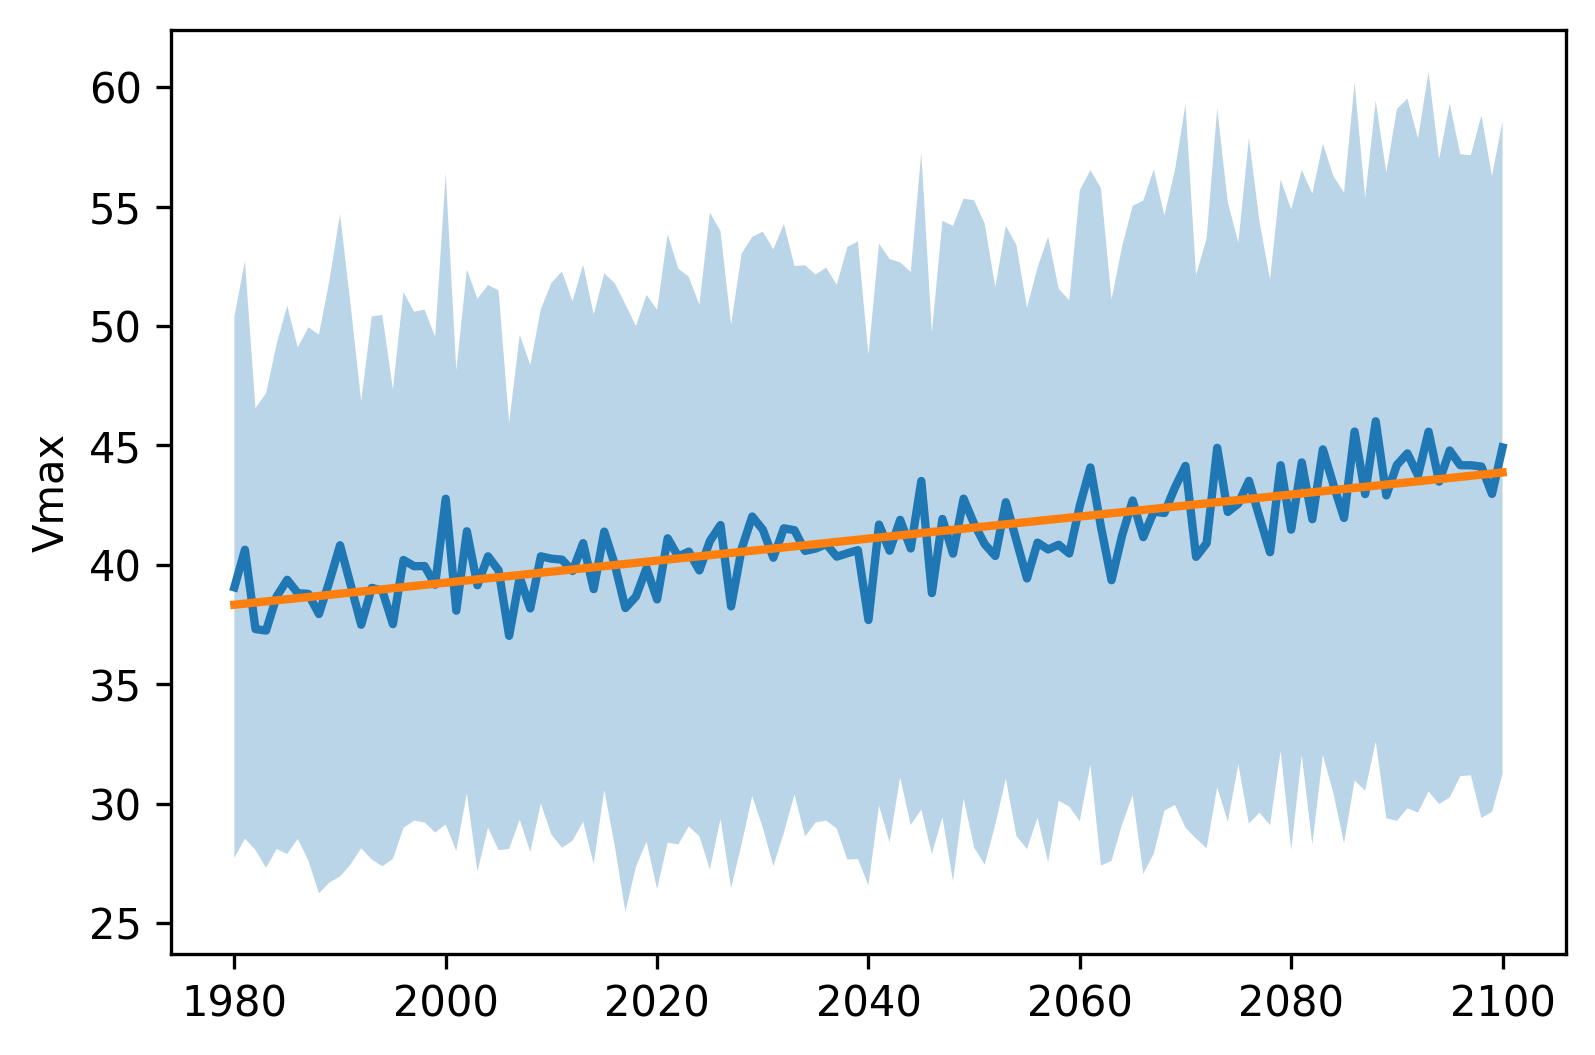

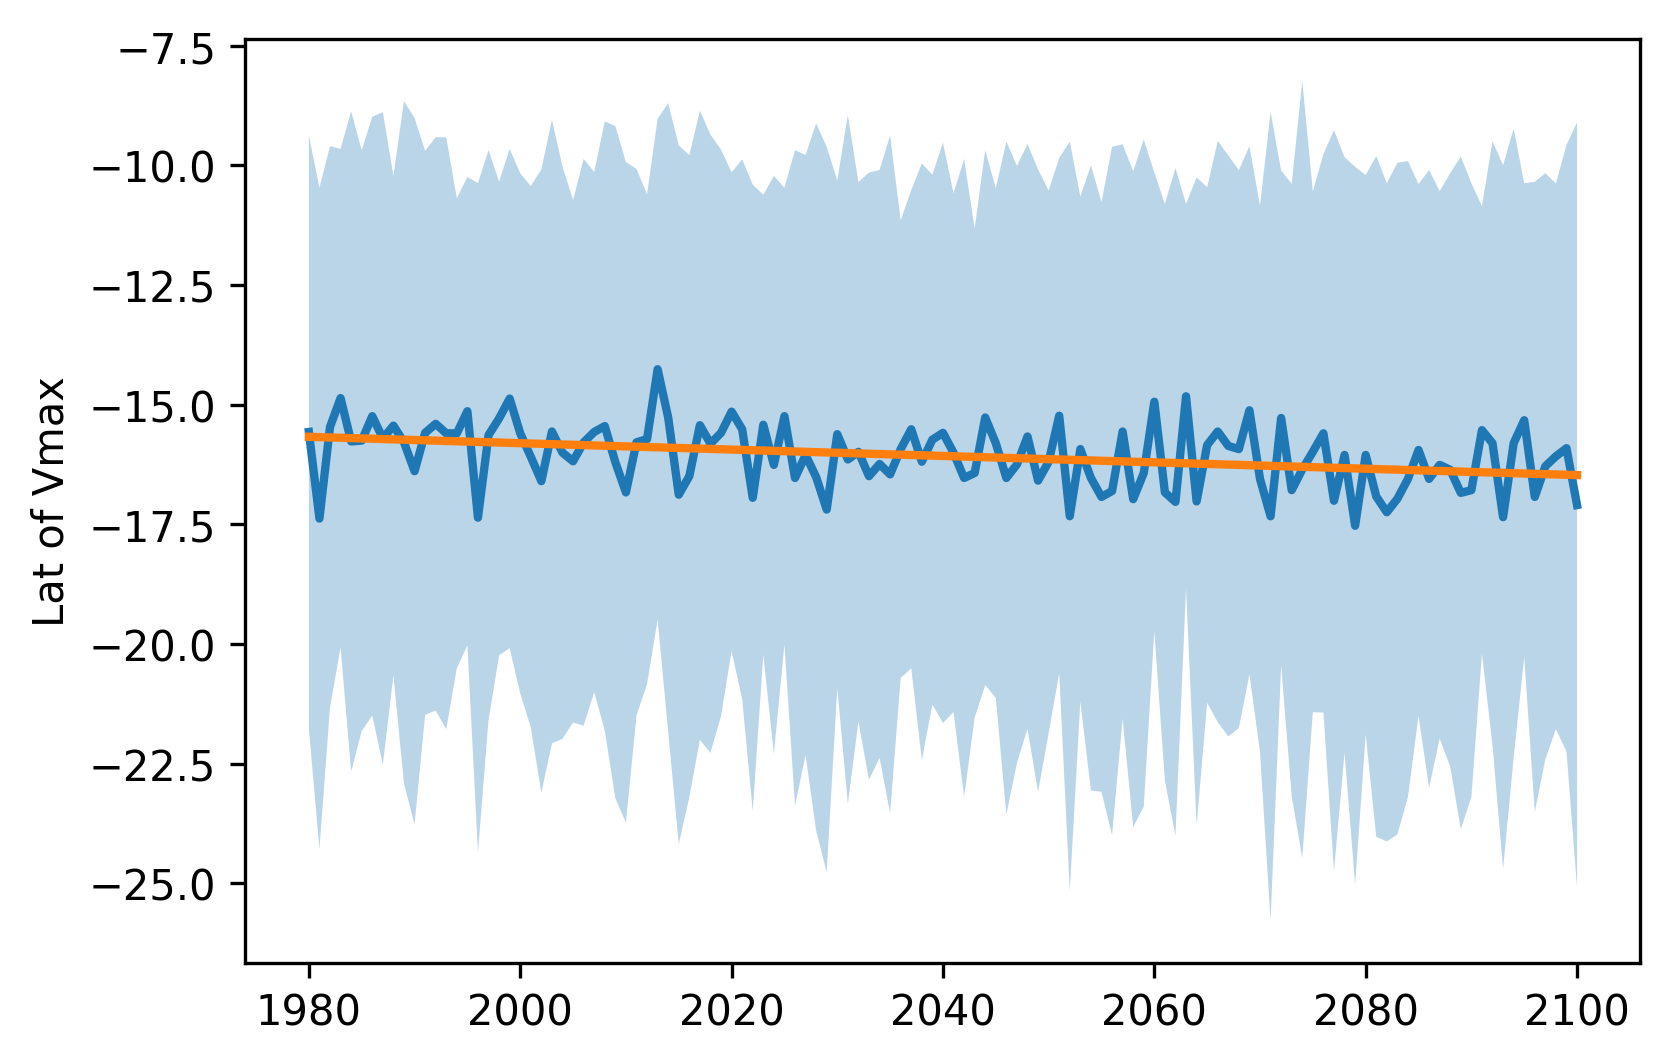

In [18]:
data_3d = rd_LENS2_info(dir_lens2, year_s, year_e, extent)
ts_trendline_en_0(year_s, year_e, data_3d)

#### 4 New Zeland
- 4.1 LENS HR 10 member

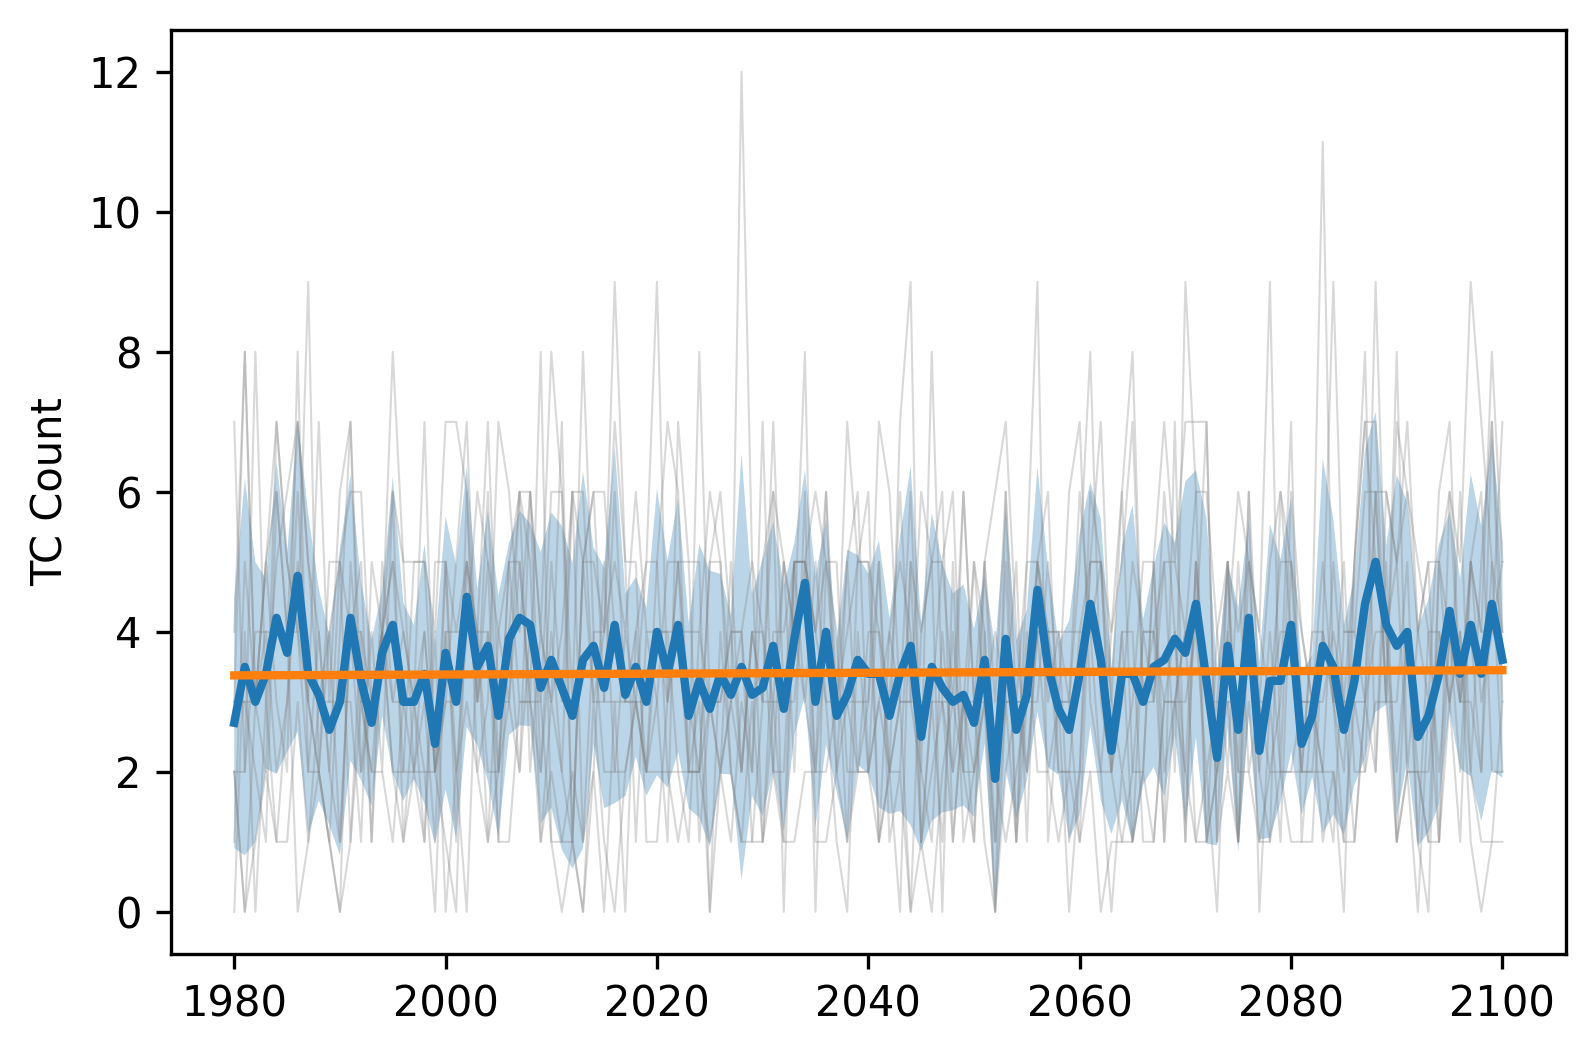

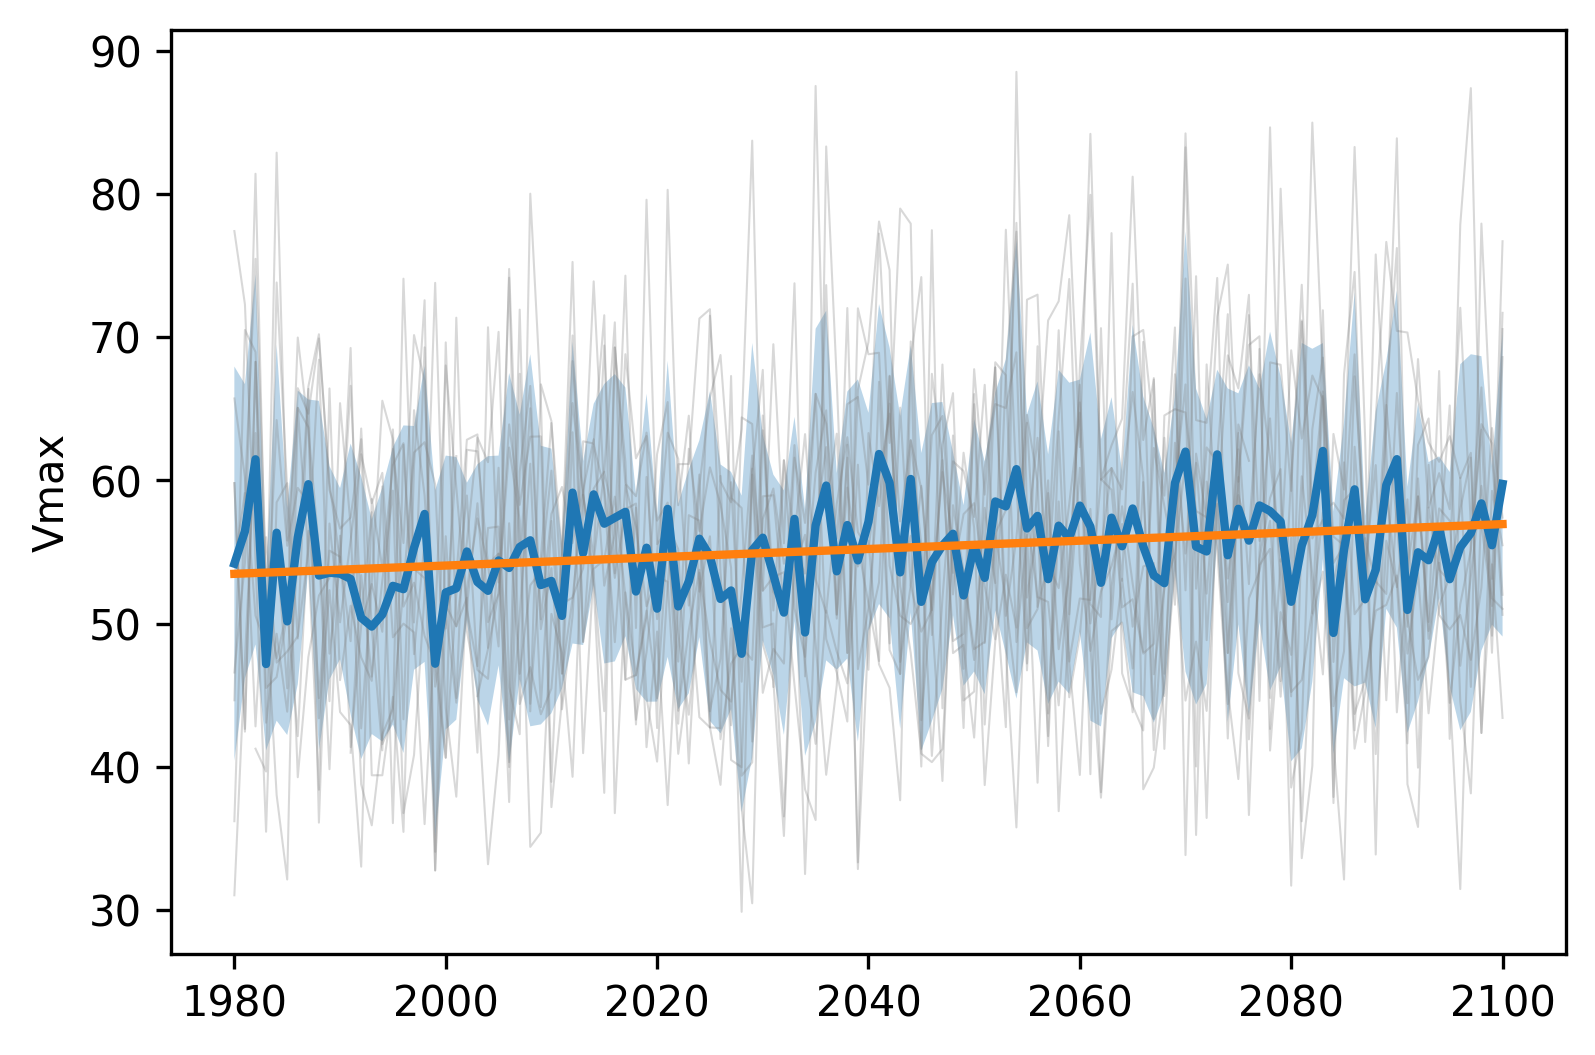

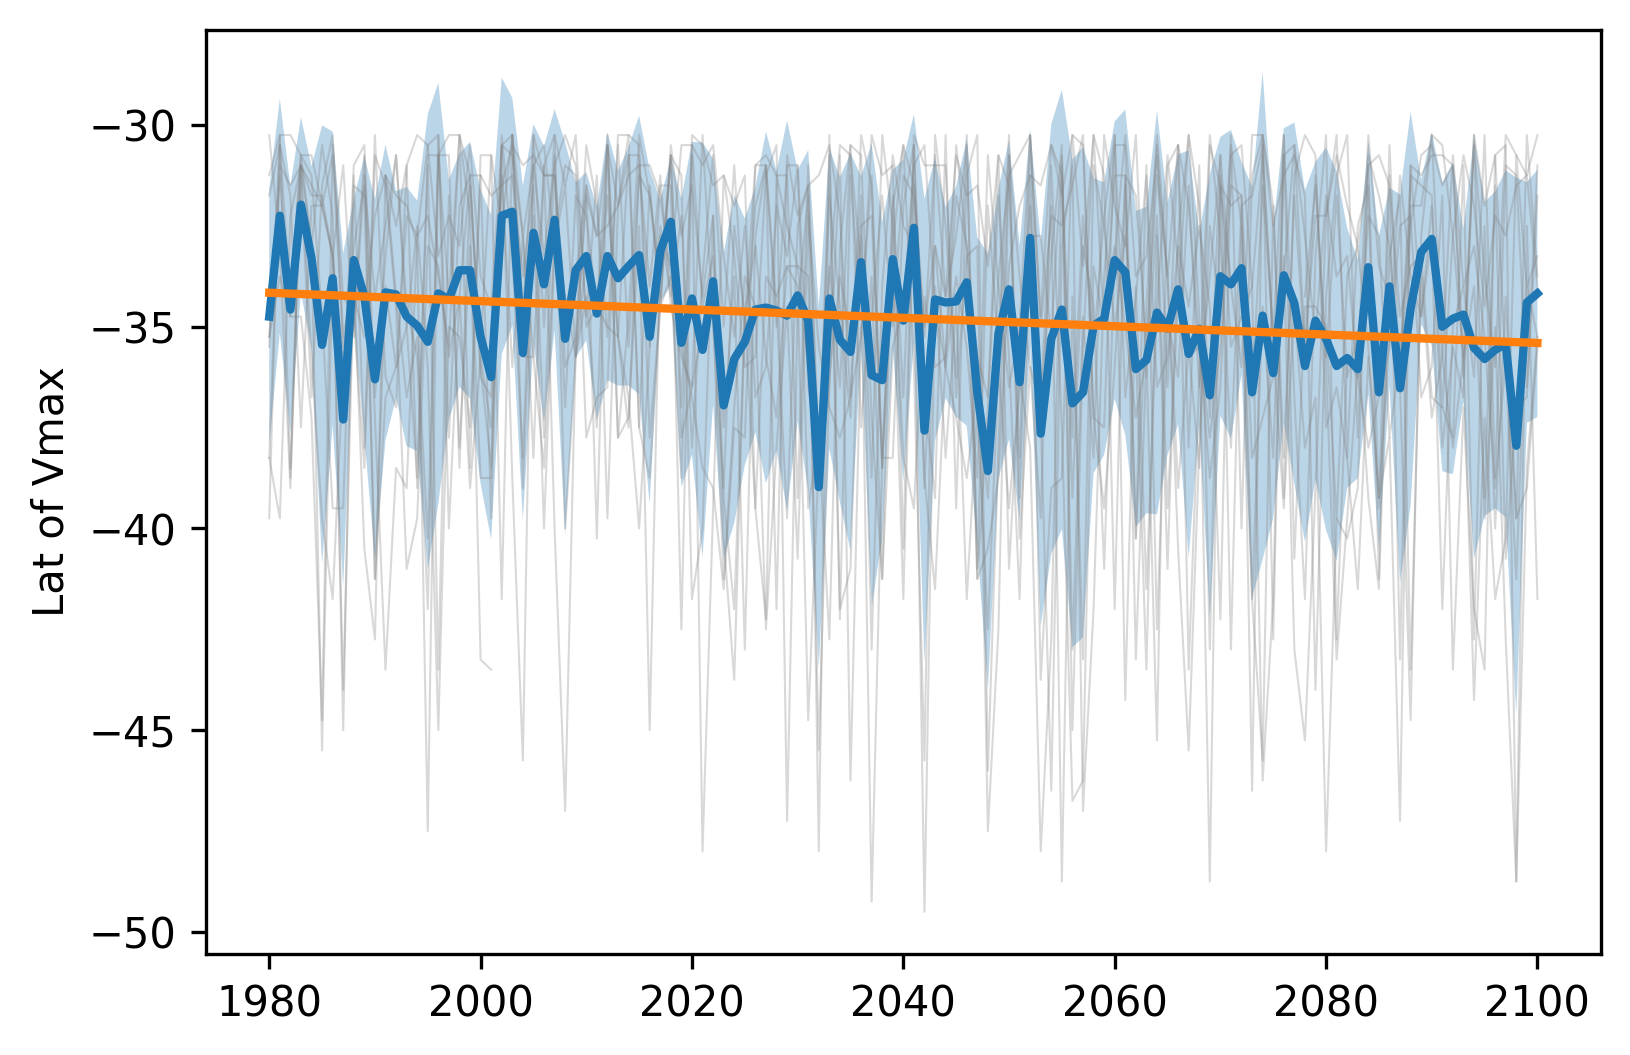

In [19]:
lon_s = 160
lon_e = 185
lat_s = -50
lat_e = -30

lon_cen = (lon_s+lon_e)*0.5
proj    = ccrs.PlateCarree(central_longitude=lon_cen)
extent = [lon_s, lon_e, lat_s, lat_e]
data_3d = rd_HR_info(dir_hr, year_s, year_e, extent) 
ts_trendline_en(year_s, year_e, data_3d) 

- 4.2 WeakThreshold 100 member

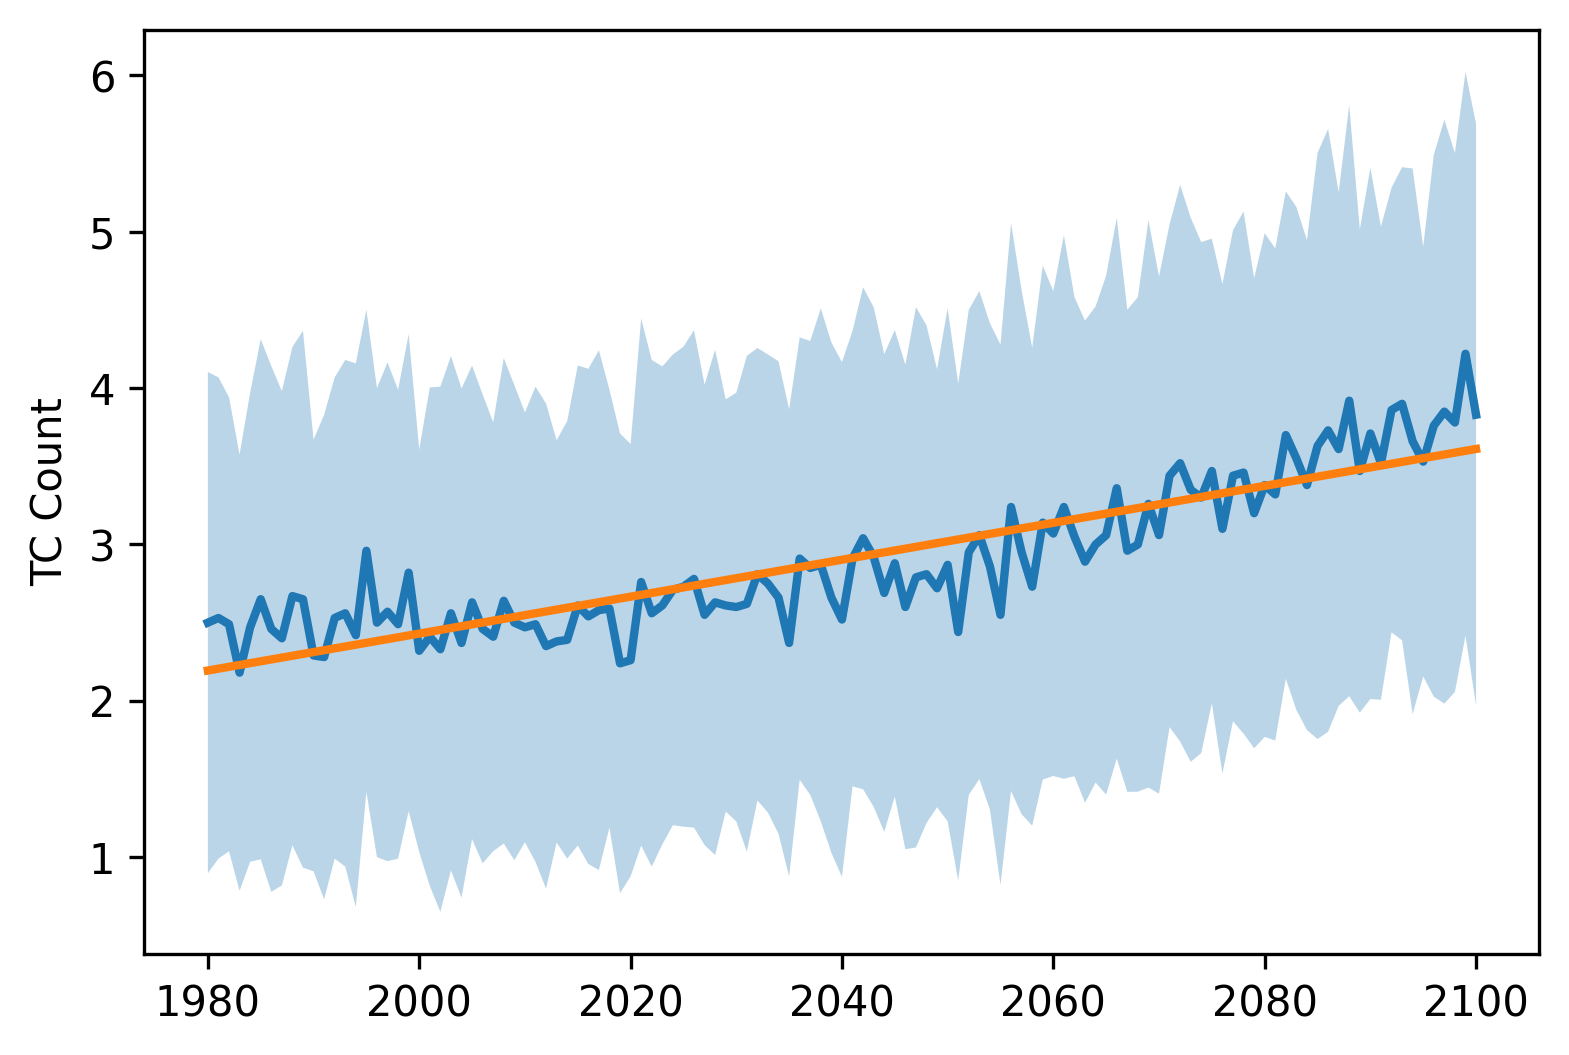

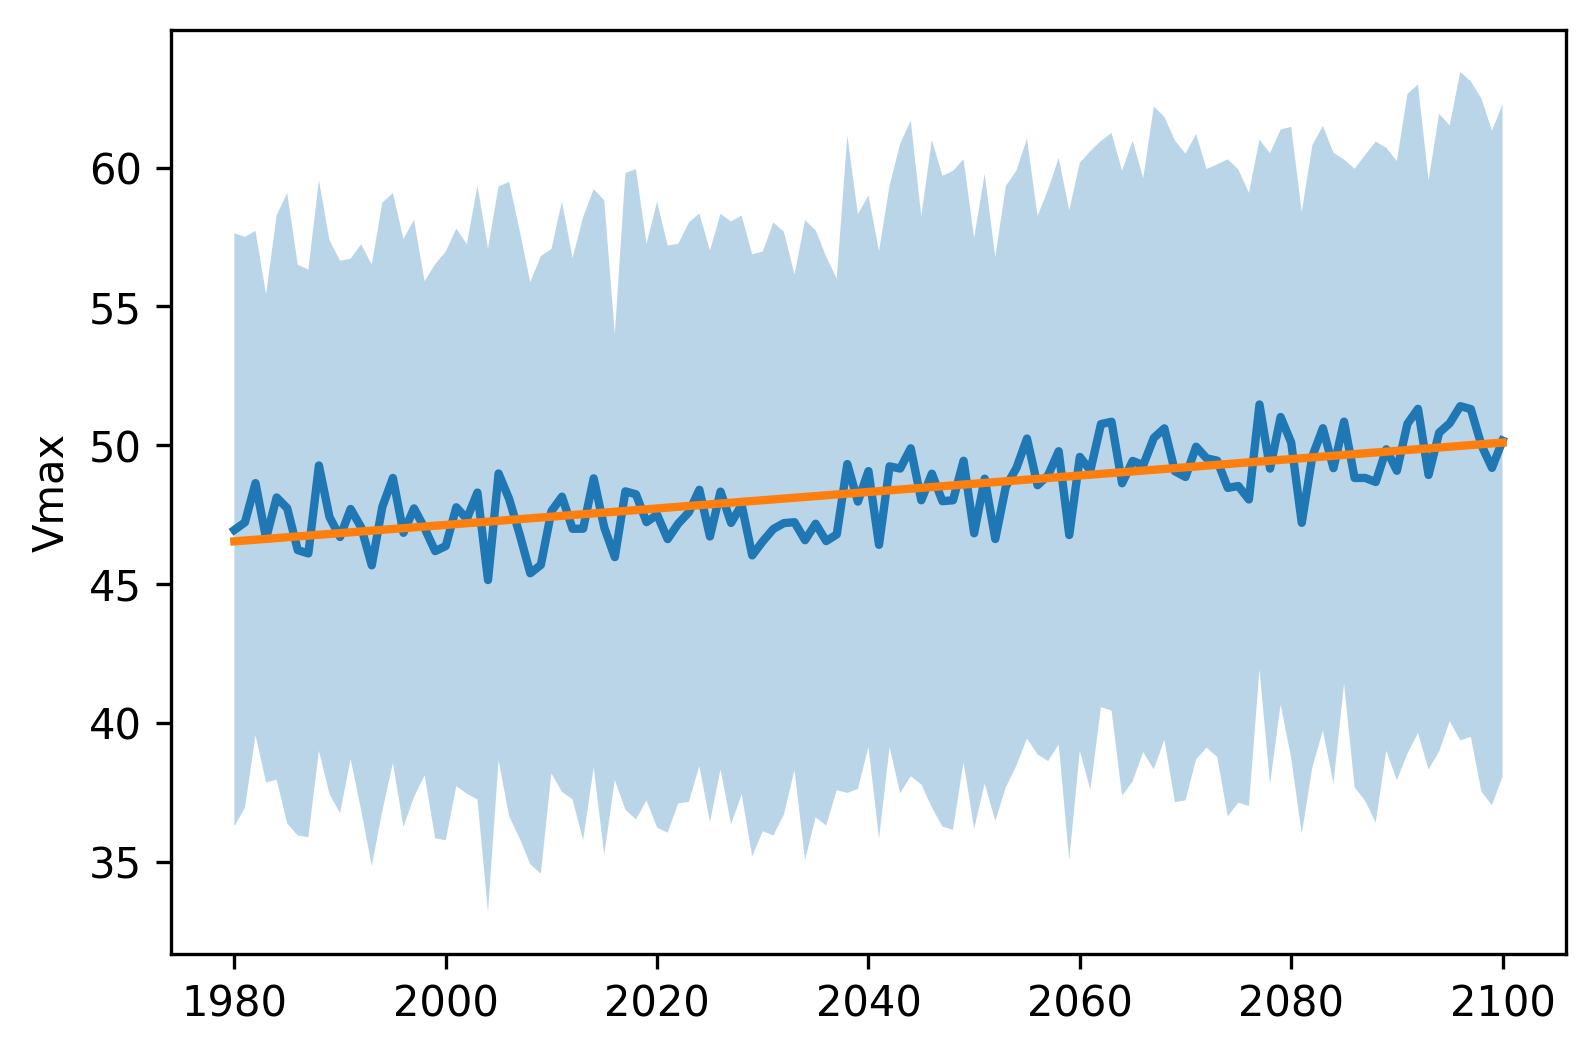

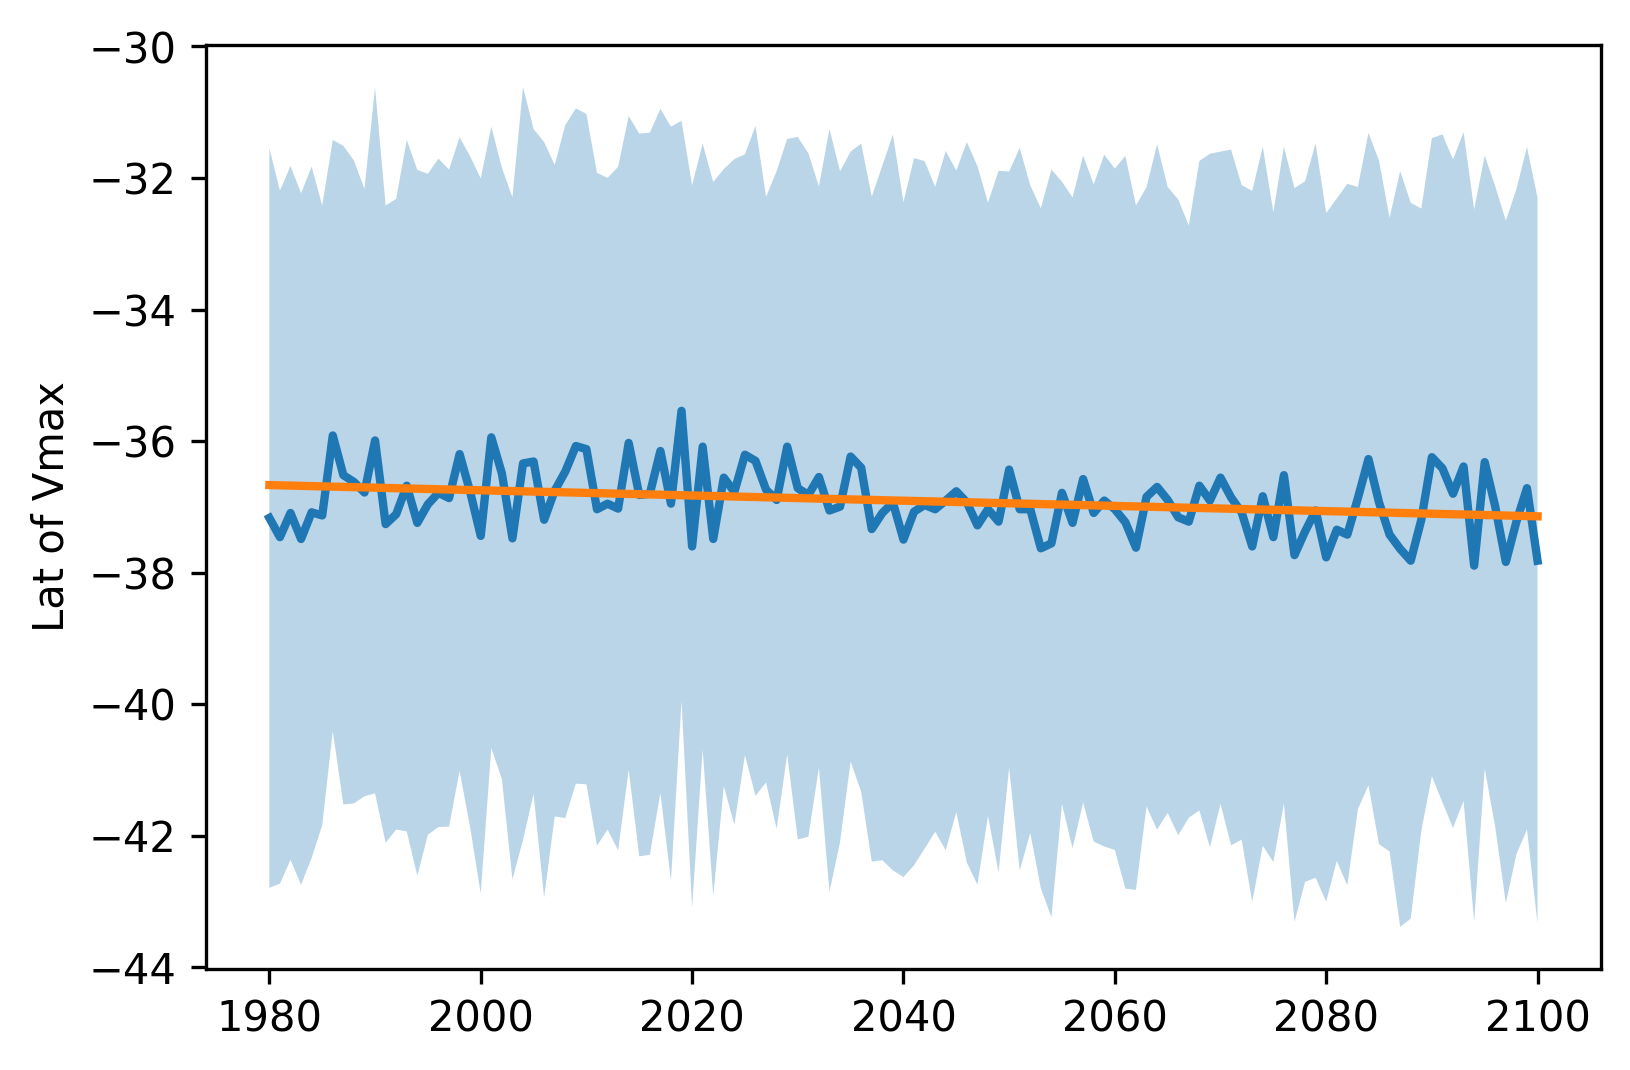

In [20]:
data_3d = rd_LENS2_info(dir_lens2, year_s, year_e, extent)
ts_trendline_en_0(year_s, year_e, data_3d) 